In [1]:
import os
import numpy as np
import itertools
import time
import random
from collections import OrderedDict, Counter, defaultdict
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

import copy
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import random_split

import math
import json
from typing import Callable, Iterable, Tuple
from torch.optim import Optimizer
from torch.utils.data import WeightedRandomSampler

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

import collections

wandb: Currently logged in as: chucooleg (use `wandb login --relogin` to force relogin)


## Data -- Generation

In [2]:
def generate_cards(attributes, attr_order, num_attributes, num_attr_vals):
    
    attr_order = attr_order[:num_attributes]
    attributes = {att_k:attributes[att_k][:num_attr_vals] for att_k in attributes if att_k in attr_order}
    
    cards = []
    idx_to_card = {}
    card_to_idx = {}

    i = 0
    attr_vals = [attributes[attr] for attr in attr_order]
    for combo in itertools.product(*attr_vals):
        card = tuple(combo)
        cards.append(card)
        card_to_idx[card] = i
        idx_to_card[i] = card
        i += 1
    
    assert len(cards) == len(set(cards))
    print(f'Generated {len(cards)} unqiue cards')                
    return cards, idx_to_card, card_to_idx


def num_shared_attributes(card1, card2):
    matching_concepts = tuple(s1 if s1==s2 else '-' for s1,s2 in zip(card1,card2))
    num_matching_concepts = len([c for c in matching_concepts if c != '-'])
    return matching_concepts, num_matching_concepts


def generate_card_pairs(cards, card_to_idx):
    '''
    find all combos of cards, filter down to the ones that share concepts.
    '''
    cardpairs_with_shared_concepts = []
    cardpairs_without_shared_concepts = []

    cardpair_to_idx, idx_to_cardpair, idx = {}, {}, 0
    num_matching_concepts_all = {}
    for card1, card2 in itertools.combinations(cards,2):
        if card1 != card2:
            matching_concepts, num_matching_concepts = num_shared_attributes(card1, card2)
            num_matching_concepts_all[(card1, card2)] = num_matching_concepts
            if num_matching_concepts:
                cardpairs_with_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            else:
                cardpairs_without_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            idx_to_cardpair[idx] = (card_to_idx[card1], card_to_idx[card2])
            cardpair_to_idx[(card_to_idx[card1], card_to_idx[card2])] = idx
            idx += 1
    print(f'Generated {len(cardpairs_with_shared_concepts) + len(cardpairs_without_shared_concepts)} cardpairs')
    print(f'-- {len(cardpairs_with_shared_concepts)} cardpairs with shared concept')
    print(f'-- {len(cardpairs_without_shared_concepts)} cardpairs without shared concept')
    print(Counter(num_matching_concepts_all.values()).most_common())
    return cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair


def match_concept_to_card(concept, card):
    '''
    Given a concept, determine if card matches.
    
    Arguments:
        concept: ('red', 'void', '-', '-')
        card: ex1. ('red', 'void', 'triangle', 'XOX')
              ex2. ('green', 'void', 'square', 'OXX')
    Returns:
        match: bool. ex1. True,
                     ex2. False
    '''
    match = 0
    for ct, cd in zip(concept, card):
        # As long as one concept matches, it is a match!
        if ct == cd:
            match += 1
    return match


def default_to_regular(d):
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.items()}
    return d

def gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=100, debug=False):
    
    # all cards
    cards, idx_to_card, card_to_idx = generate_cards(attributes, attr_order, num_attributes, num_attr_vals)
    # all card pairs
    cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair = \
        generate_card_pairs(cards, card_to_idx)
    
    # generate answers
    all_matches = []
    number_of_shared_concepts_per_match = []
    cardpair_to_matches = defaultdict(lambda : defaultdict(int))
#     for cardpair in cardpairs_with_shared_concepts + cardpairs_without_shared_concepts: # NOTE!!
    for cardpair in cardpairs_with_shared_concepts:
        shared_concept = cardpair[1]
        # look for all matching cards
        # ((card pair query), matching card)
        for card in cards:
            num_matched_concepts = match_concept_to_card(shared_concept, card)
            if num_matched_concepts:
                all_matches.append((cardpair_to_idx[cardpair[0]], card_to_idx[card]))
                cardpair_to_matches[cardpair_to_idx[cardpair[0]]][card_to_idx[card]] = num_matched_concepts
                number_of_shared_concepts_per_match.append(num_matched_concepts)
    cardpair_to_matches = default_to_regular(cardpair_to_matches)
    print('Total number of matches = ', len(all_matches))
    print('Number of shared concepts per match = ', Counter(number_of_shared_concepts_per_match).most_common())
    
    # hold out some cardpairs
    unseen_cardpair_indices = list(np.random.choice(len(cardpair_to_idx), size=num_unseen_cardpairs, replace=False))
    train_cardpair_indices = [idx for idx in range(len(cardpair_to_idx)) if idx not in unseen_cardpair_indices]
    assert len(set(unseen_cardpair_indices) | set(train_cardpair_indices)) == len(cardpair_to_idx)
    
    data = {
        'idx_to_key': idx_to_card,
        'key_to_idx': card_to_idx,
        'query_to_idx': cardpair_to_idx, 
        'idx_to_query': idx_to_cardpair,
        'all_matches': all_matches, # list of tuples (query idx, answer card)
        'query_to_keys': cardpair_to_matches, # lookup query idx:{'card1':num matched concepts, 'card2':num matched concepts,...}
        'unseen_query_indices': unseen_cardpair_indices,
        'seen_query_indices': train_cardpair_indices
    }
    return data


attributes = {
    'color': ['red', 'green', 'blue', 'orange', 'cyan', 'magenta', 'black', 'yellow'],
    'fill': ['void', 'dashed', 'solid', 'checkered', 'dotted', 'mosaic', 'noise', 'brushed'],
    'shape': ['square', 'circle', 'triangle', 'star', 'hexagon', 'pentagon', 'ellipse', 'rectangle'],
    'config': ['OOO', 'OOX', 'OXO', 'OXX', 'XOO', 'XOX', 'XXO', 'XXX']
}

attr_order = ['color', 'fill', 'shape', 'config']

num_attributes = 4
num_attr_vals = 4
game_data = gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)

Generated 256 unqiue cards
Generated 32640 cardpairs
-- 22272 cardpairs with shared concept
-- 10368 cardpairs without shared concept
[(1, 13824), (0, 10368), (2, 6912), (3, 1536)]
Total number of matches =  1886208
Number of shared concepts per match =  [(1, 1714176), (2, 165888), (3, 6144)]


## Data -- Distribution, Splits

In [3]:
distribution_epsilon = 1e-100

count_table = np.zeros((len(game_data['idx_to_key']), len(game_data['idx_to_query'])))
        
for q, k in game_data['all_matches']:
    count_table[k, q] += 1    
        
xy = count_table/np.sum(count_table)
xy += distribution_epsilon
xy /= np.sum(xy)

x = np.sum(xy,0)
y = np.sum(xy,1)
xyind = y[None].T @ x[None]

In [4]:
# + 0.1
[(0.0029940119760479044, 270), (0.003548458638278998, 54)]
# + nothing
Counter(list(xy.reshape(-1))).most_common()

[(1.0000000000000007e-100, 6469632), (5.301642236699243e-07, 1886208)]

In [5]:
np.sum(count_table)

1886208.0

In [6]:
xy_rank = np.linalg.matrix_rank(xy)
print('xy_rank=',xy_rank)

xy_div_xyind_rank = np.linalg.matrix_rank((xy/xyind))
print('xy_div_xyind_rank=',xy_div_xyind_rank)

xy_rank= 175
xy_div_xyind_rank= 175


In [7]:
figsize = (20,15)
# figrange = (fx_s, fx_e, fy_s, fy_e)
figrange = (0, len(game_data['idx_to_key']), 0, len(game_data['idx_to_query']))

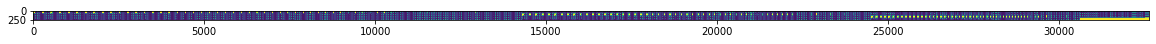

In [8]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

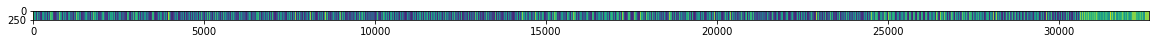

In [9]:
# all
plt.figure(figsize = figsize)
plt.imshow((xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

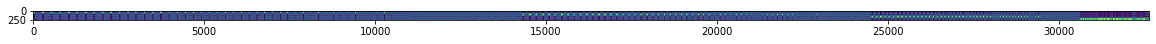

In [10]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [19]:
figsize = (20,15)
# figrange = (fx_s, fx_e, fy_s, fy_e)
figrange = (0, len(game_data['idx_to_key']), 0, 900)

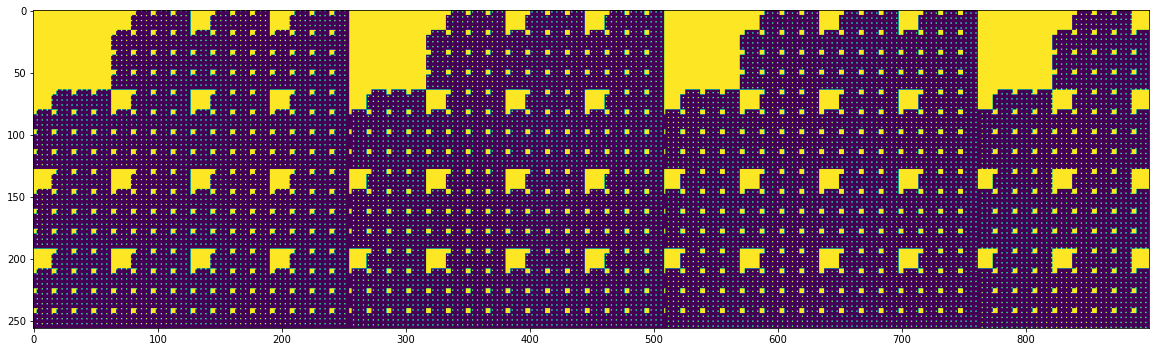

In [20]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

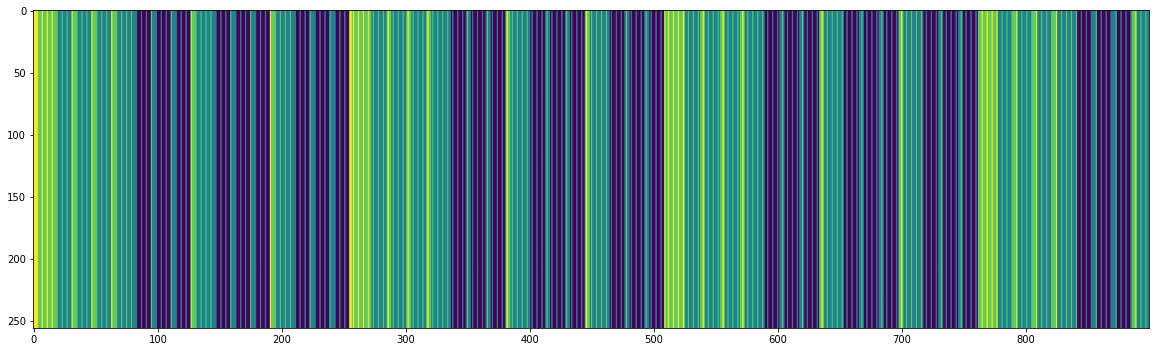

In [21]:
# all
plt.figure(figsize = figsize)
plt.imshow((xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

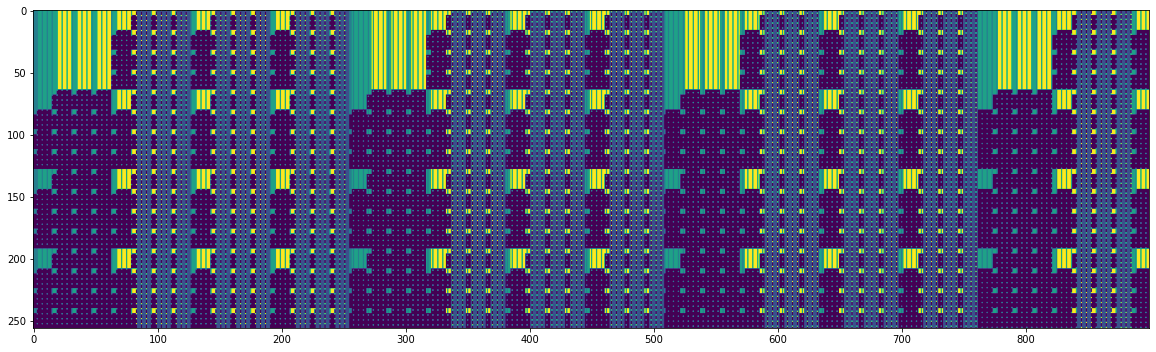

In [22]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [16]:
Counter(list((xy/xyind).reshape(-1))).most_common()

[(7.544831999999994e-94, 1679616),
 (1.0000000000000036, 1679616),
 (1.0000000000000038, 974592),
 (7.544831999999995e-94, 974592),
 (4.311332571428568e-94, 629856),
 (3.999999999999997, 559872),
 (2.285714285714284, 489888),
 (4.3113325714285687e-94, 365472),
 (3.999999999999998, 324864),
 (2.2857142857142843, 284256),
 (1.7297297297297283, 143856),
 (3.262630054054051e-94, 104976),
 (1.7297297297297285, 83472),
 (3.2626300540540517e-94, 60912)]

## Dataset

In [23]:
### One embed per query!

class GameDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return self.query_support_size * self.key_support_size
    
    def __getitem__(self, idx):
        '''
        key_idx: (xy_i) * (xy.shape[1]=self.query_support_size) + (xy_j)
        '''
        x_i, y_j = idx//self.query_support_size, idx%self.query_support_size
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0
        
        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('key\n', x_i, self.raw_data['idx_to_key'][x_i])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
        
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        )    

game_dataset = GameDataset(raw_data=game_data, debug=True)
game_dataset[10] 
print('-----')
game_dataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void', 'square', 'OOO') ('red', 'void', 'triangle', 'OXX')
key
 0 ('red', 'void', 'square', 'OOO')
all matches 
 [('red', 'void', 'square', 'OOO'), ('red', 'void', 'square', 'OOX'), ('red', 'void', 'square', 'OXO'), ('red', 'void', 'square', 'OXX'), ('red', 'void', 'circle', 'OOO'), ('red', 'void', 'circle', 'OOX'), ('red', 'void', 'circle', 'OXO'), ('red', 'void', 'circle', 'OXX'), ('red', 'void', 'triangle', 'OOO'), ('red', 'void', 'triangle', 'OOX'), ('red', 'void', 'triangle', 'OXO'), ('red', 'void', 'triangle', 'OXX'), ('red', 'void', 'star', 'OOO'), ('red', 'void', 'star', 'OOX'), ('red', 'void', 'star', 'OXO'), ('red', 'void', 'star', 'OXX'), ('red', 'dashed', 'square', 'OOO'), ('red', 'dashed', 'square', 'OOX'), ('red', 'dashed', 'square', 'OXO'), ('red', 'dashed', 'square', 'OXX'), ('red', 'dashed', 'circle', 'OOO'), ('red', 'dashed', 'circle', 'OOX'), ('red', 'dashed', 'circle', 'OXO'), ('red', 'dashed', 'circle', 'OXX'), ('red', 'dashed', 'triangle'

(7,
 tensor([7]),
 tensor([0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
         1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
         1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
         1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
         1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
         1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]))

In [24]:
class GameTestFullDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        queries_with_shared_attr_only: bool.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return len(self.raw_data['idx_to_query'])
    
    def __getitem__(self, idx):
        '''
        key_idx: int. 0 to query_support_size-1
        '''
        y_j = idx
        x_i = torch.empty(1) # just a meaningless value
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0

        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
            
            
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        ) 
    
game_testdataset = GameTestFullDataset(raw_data=game_data, debug=True)
game_testdataset[10]
print('-----')
game_testdataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void', 'square', 'OOO') ('red', 'void', 'triangle', 'OXX')
all matches 
 [('red', 'void', 'square', 'OOO'), ('red', 'void', 'square', 'OOX'), ('red', 'void', 'square', 'OXO'), ('red', 'void', 'square', 'OXX'), ('red', 'void', 'circle', 'OOO'), ('red', 'void', 'circle', 'OOX'), ('red', 'void', 'circle', 'OXO'), ('red', 'void', 'circle', 'OXX'), ('red', 'void', 'triangle', 'OOO'), ('red', 'void', 'triangle', 'OOX'), ('red', 'void', 'triangle', 'OXO'), ('red', 'void', 'triangle', 'OXX'), ('red', 'void', 'star', 'OOO'), ('red', 'void', 'star', 'OOX'), ('red', 'void', 'star', 'OXO'), ('red', 'void', 'star', 'OXX'), ('red', 'dashed', 'square', 'OOO'), ('red', 'dashed', 'square', 'OOX'), ('red', 'dashed', 'square', 'OXO'), ('red', 'dashed', 'square', 'OXX'), ('red', 'dashed', 'circle', 'OOO'), ('red', 'dashed', 'circle', 'OOX'), ('red', 'dashed', 'circle', 'OXO'), ('red', 'dashed', 'circle', 'OXX'), ('red', 'dashed', 'triangle', 'OOO'), ('red', 'dashed', 'triangle', 

(7,
 tensor([7]),
 tensor([7823]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
         1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
         1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
         1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
         1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
         1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]))

In [25]:
class GameDataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size, raw_data, seen_train_xy, seen_val_xy, debug=False):
        super().__init__()
        self.batch_size = batch_size
        self.dataset = GameDataset(raw_data=raw_data, debug=debug)
#         self.testdataset = GameTestFullDataset(raw_data=raw_data, debug=debug)
        self.seen_train_xy = seen_train_xy
        self.seen_val_xy = seen_val_xy
        self.setup_samplers()
        
    def setup_samplers(self):
        self.train_sampler = WeightedRandomSampler(
            weights=self.seen_train_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        ) 
        self.val_sampler = WeightedRandomSampler(
            weights=self.seen_val_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        )
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train = self.dataset
            self.val = self.dataset
#         if stage == 'test' or stage is None:
#             self.test = self.testdataset
            
    def train_dataloader(self):
        train_loader = DataLoader(
            self.train, batch_size=self.batch_size, shuffle=False, sampler=self.train_sampler
        )
        return train_loader
    
    def val_dataloader(self):
        val_loader = DataLoader(
            self.val, batch_size=self.batch_size,  shuffle=False, sampler=self.val_sampler
        )
        return val_loader
    
#     def test_dataloader(self):
#         test_loader = DataLoader(
#             self.test, batch_size=self.batch_size, shuffle=False
#         )
#         return test_loader  

## Model Architecture

In [26]:
def construct_full_model(hparams):
    '''
    return: nn.Module.
    '''
    # embeddings
    query_embed_X = ScaledEmbedding(hparams['query_support_size'], hparams['d_model'])
    key_embed_X = ScaledEmbedding(hparams['key_support_size'], hparams['d_model'])
    embed_dropout = nn.Dropout(hparams['embed_dropout'])
    
    # full model
    model = EncoderPredictor(
        inp_query_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', query_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        inp_key_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', key_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        classifier = nn.Sequential(
            OrderedDict([   
                ('linear1', nn.Linear(2*hparams['d_model'], hparams['d_model'])),
                ('nonLinear1', nn.ReLU()),
                ('linear-out', nn.Linear(hparams['d_model'], 1)),
            ])
        ) if not hparams['dotproduct_bottleneck'] else None, 
        
        key_support_size = hparams['key_support_size'],
        d_model = hparams['d_model'],
        debug = hparams['debug'],
    )
    
    return model

In [27]:
class ScaledEmbedding(nn.Module):

    def __init__(self, V, d_model):
        super(ScaledEmbedding, self).__init__()
        self.embedding = nn.Embedding(V, d_model)
        # scale embedding to have variance 0.01
        nn.init.normal_(self.embedding.weight, mean=0., std=(0.01)**(1/2))
        self.d_model = d_model

    def forward(self, tokens):
        '''
        tokens: shape (batch_size=b, len)
        '''
        # shape (b, len, d_model)
        embedded = self.embedding(tokens) * math.sqrt(self.d_model)
        if torch.max(embedded) > 2000.:
            import pdb; pdb.set_trace()
        return embedded

In [28]:
class EncoderPredictor(nn.Module):
    
    def __init__(self, inp_query_layer, inp_key_layer, classifier, key_support_size, d_model, debug=False):
        super().__init__()
        self.inp_query_layer = inp_query_layer
        self.inp_key_layer = inp_key_layer
        self.classifier = classifier
        self.key_support_size = key_support_size
        self.d_model = d_model
        
    def forward(self, X_query, X_key, val_bool, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1) if test bool, else (b, num matched cards) or None.
        '''
        if X_key is not None: assert X_query.shape == X_key.shape
        if val_bool:
            return self.forward_norm_support(X_query, debug=debug)
        else:
            assert X_key is not None, 'X_key should not be None for normalizing over minibatch keys.'
            return self.forward_norm_minibatch(X_query, X_key, debug=debug)

    def forward_norm_minibatch(self, X_query, X_key, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)
        
        # shape(b, d_model)
        key_repr = self.encode_key(X_key).squeeze(1)
        assert key_repr.shape == (b, self.d_model)

        if self.classifier:
            raise ValueError('Not supposed to use classifier!')
            # shape(b, b, d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, b, self.d_model)
            # shape(b, b, d_model)
            key_repr_tiled = key_repr.unsqueeze(0).expand(b, b, self.d_model)
            # shape(b, b, 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            assert query_key_concat.shape == (b, b, 2*self.d_model)
            # shape(b*b, 2*d_model)
            query_key_concat = query_key_concat.reshape(b*b, 2*self.d_model)
            # shape(b*b, 1)
            logits = self.classifier(query_key_concat)
            assert logits.shape == (b*b, 1)
            # shape(b, b)
            logits = logits.squeeze(1).reshape(b, b)
        else:
            # shape(b, b) dotproduct=logit matrix
            logits = torch.matmul(query_repr, key_repr.T)
        assert logits.shape == (b, b)
        
        # shape(b, b)
        return logits

    def forward_norm_support(self, X_query, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)

        # shape(size(support), d_model)
        keys_repr = self.encode_all_keys()
        assert keys_repr.shape == (self.key_support_size, self.d_model)
        
        if self.classifier:
            # shape(b, size(support), d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), d_model)
            key_repr_tiled = keys_repr.unsqueeze(0).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            # shape(b*size(support), 2*d_model)
            query_key_concat = query_key_concat.reshape(b*self.key_support_size, 2*self.d_model)
            # shape(b*size(support), 1)
            logits = self.classifier(query_key_concat)
            # shape(b, size(support))
            logits = logits.squeeze(1).reshape(b, self.key_support_size)
        else:
            # shape(b, size(support)) dotproduct=logit matrix
            logits = torch.matmul(query_repr, keys_repr.T)
        assert logits.shape == (b, self.key_support_size)
        
        # shape(b, size(support)) 
        return logits

    def encode_query(self, X):
        '''
        X: (batch_size=b,1)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_query_layer(X)
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed     
        
    def encode_key(self, X):
        '''
        X: (batch_size=b)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_key_layer(X) 
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed  

    def encode_all_keys(self):
        
        # shape(size(support), embed_dim)
        all_embed = self.inp_key_layer.scaled_embed.embedding.weight
        assert all_embed.requires_grad == True
        assert all_embed.shape == (self.key_support_size, self.d_model)
        
        return all_embed

## Loss, Metric

In [29]:
class InfoCELoss(nn.Module):
    '''
    InfoCE Loss on a (b, b) logits matrix with Temperature scaling
    '''

    def __init__(self, temperature_const=1.0):
        super().__init__()
        self.temperature_const = temperature_const
        self.CE_loss = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, logits, debug=False):
        '''
        logits: shape (batch_size=b, b)
        '''
        assert logits.shape[0] == logits.shape[1]
        b = logits.shape[0]
        
        logits /= self.temperature_const
        
        labels = torch.arange(b).type_as(logits).long()
        sum_loss_per_row = self.CE_loss(logits, labels)
        sum_loss_per_col = self.CE_loss(logits.T, labels)
        
        if debug:
            print('sum_loss_per_row=',sum_loss_per_row)
            print('sum_loss_per_col=',sum_loss_per_col)

        loss = (sum_loss_per_row + sum_loss_per_col) * 0.5
        return loss


# ---------------------------    
loss_criterion = InfoCELoss(temperature_const=0.1)

logits = torch.tensor([
    [1.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))
print('-------------')
logits = torch.tensor([
    [3.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))


# ref
# sum_loss_per_row= tensor(20.0001)
# sum_loss_per_col= tensor(60.0001)
# avg loss= tensor(40.0001)
# -------------
# sum_loss_per_row= tensor(0.6933)
# sum_loss_per_col= tensor(40.0001)
# avg loss= tensor(20.3467)

sum_loss_per_row= tensor(20.0001)
sum_loss_per_col= tensor(60.0001)
avg loss= tensor(40.0001)
-------------
sum_loss_per_row= tensor(0.6933)
sum_loss_per_col= tensor(40.0001)
avg loss= tensor(20.3467)


In [30]:
class ThresholdedMetrics(nn.Module):
    
    def __init__(self, raw_data):
        '''
        tot_k: total number of candidates. e.g. 81 cards
        '''
        super().__init__()
        self.raw_data = raw_data
        self.key_support_size = len(self.raw_data['idx_to_key'])
        self.threshold = 1.0 / (self.key_support_size)
        self.softmax = nn.Softmax(dim=1)

    def breakdown_errors(self, X_query, corrects):
        '''
        X_query: shape (b,1) (if one embed per query)
        corrects: shape (b, support size)
        '''
        b = X_query.shape[0]
        assert corrects.shape == (b, self.key_support_size)
        
        X_query_list = X_query.squeeze(-1)
        wrongs = (1 - corrects).cpu().numpy()
        
        num_matched_concepts = [
             self.raw_data['query_to_keys'].get(X_query_list[batch_i].item(), {}).get(card_idx, 0)
            for batch_i in range(b) for card_idx in range(self.key_support_size)  
        ]
        
        num_matched_concepts = np.array(num_matched_concepts).reshape(b, self.key_support_size)
        assert num_matched_concepts.shape == wrongs.shape
        
        wrongs_mask = wrongs.reshape(-1).tolist()
        num_matched_concepts = num_matched_concepts.reshape(-1).tolist()

        error_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        total_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        for w,k in zip(wrongs_mask, num_matched_concepts):
            if w == 1:
                error_count_by_num_matched_concepts[k] += 1
            total_count_by_num_matched_concepts[k] += 1    

        error_counts, total_counts = {}, {}
        for k in range(num_attributes):
            err_ct = error_count_by_num_matched_concepts[k]
            tot_ct = total_count_by_num_matched_concepts[k]
            error_counts[f'error_rate_for_{k}_matched_concepts'] = 0 if tot_ct == 0 else (err_ct *1.0 / tot_ct)
            total_counts[f'total_count_for_{k}_matched_concepts'] = tot_ct

        return {**error_counts, **total_counts}    
    
    def forward(self, X_query, logits, X_keys, full_test_bool=False, breakdown_errors_bool=False, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        b, key_support_size = logits.shape
        assert key_support_size == self.key_support_size
        assert logits.shape == X_keys.shape
        
        if full_test_bool:
            # filter down to query cards with >0 true matches
            queryIdxs_with_nonzero_matches = list(self.raw_data['query_to_keys'].keys())
            X_query_flat = X_query.squeeze(-1)
            fil = torch.stack([(X_query_flat == qId) for qId in queryIdxs_with_nonzero_matches], dim=1).any(dim=1)
            assert fil.shape == (b, )
            
            # queries with shared attributes
            fil_metrics = self.compute_metrics(X_query[fil], logits[fil], X_keys[fil], breakdown_errors_bool, debug)
            fil_metrics = {'nonNullQueries_'+k:fil_metrics[k] for k in fil_metrics}
            
            # queries without shared attributes
            not_fil = torch.logical_not(fil)
            not_fil_metrics = self.compute_metrics(X_query[not_fil], logits[not_fil], X_keys[not_fil], breakdown_errors_bool, debug)
            not_fil_metrics = {'NullQueries_'+k:not_fil_metrics[k] for k in not_fil_metrics}
            
            # all queries
            all_metrics = self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
            
            return {**fil_metrics, **not_fil_metrics, **all_metrics}
        else:
            return self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
    
    def compute_metrics(self, X_query, logits, X_keys, breakdown_errors_bool=False, debug=False):
        '''
        X_query: shape (b,1) (if one embed per query)
        logits: shape (b, support size)
        X_keys: shape (b, support size). value 1.0 at where card matches. value 0 otherwise.
        '''
        b, key_support_size = logits.shape
        
        # model predictions, shape (b, support size)
        binary_predictions = (self.softmax(logits) >= self.threshold).type(torch.float)
        # ground truth, shape (b, support size)
        gt = X_keys
        # correct predictions, shape (b, support size)
        corrects = (binary_predictions == gt).type(torch.float)
        
        # accuracy, computed per query, average across queries
        # (b,)
        accuracy_row = torch.sum(corrects, dim=1) / key_support_size
        # scalar
        accuracy_meanrows = torch.mean(accuracy_row)
        # accuracy, computed per query-key, average across all
        accuracy_all = torch.sum(corrects) / (b * key_support_size)
        
        # precision, computed per query, average across queries
        # (b,)
        precision_row = torch.sum((corrects * binary_predictions), dim=1) / torch.sum(binary_predictions, dim=1)
        # scalar
        precision_meanrows = torch.mean(precision_row)
        # precision, computed per query-key, average across all
        precision_all = torch.sum((corrects * binary_predictions)) / torch.sum(binary_predictions)

        # recall, computed per query, average across queries
        # (b,)
        recall_row = torch.sum((corrects * gt), dim=1) / torch.sum(gt, dim=1)
        # scalar
        recall_meanrows = torch.mean(recall_row)
        # recall, computed per query-key, average across all
        recall_all = torch.sum((corrects * gt)) / torch.sum(gt)
        
        # f1, computed per query, average across queries
        # (b,)
        f1_row = 2 * (precision_row * recall_row) / (precision_row + recall_row)
        # scalar
        f1_meanrows = torch.mean(f1_row)
        # f1, computed per query-key, average across all
        f1_all = (precision_all * recall_all) / (precision_all + recall_all)
        
        if breakdown_errors_bool:
            error_breakdown_by_num_matched_concepts = self.breakdown_errors(X_query, corrects)
        else:
            error_breakdown_by_num_matched_concepts = {} 
            
        if debug:
            print('####################################################')
            print('Metrics Per Query:')
            print('accuracy_rows', accuracy_row)
            print('precision_row', precision_row)
            print('recall_row', recall_row)
            print('f1_row', f1_row)
            print('####################################################')
            print('Metrics Averaged Across Queries')
            print('accuracy_meanrows', accuracy_meanrows)
            print('precision_meanrows', precision_meanrows)
            print('recall_meanrows', recall_meanrows)
            print('f1_meanrows', f1_meanrows)
            print('####################################################')
            print('Metrics Averaged Across All Query-Key Pairs:')
            print('accuracy_all', accuracy_all)
            print('precision_all', precision_all)
            print('recall_all', recall_all)
            print('f1_all', f1_all)
            print('####################################################')
            print('error_breakdown', error_breakdown_by_num_matched_concepts)
            
        metrics = {
            'accuracy_by_Query': accuracy_meanrows,
            'precision_by_Query': precision_meanrows,
            'recall_by_Query': recall_meanrows,
            'f1_by_Query': f1_meanrows,
            'accuracy_by_QueryKey': accuracy_all,
            'precision_by_QueryKey': precision_all,
            'recall_by_QueryKey': recall_all,
            'f1_by_QueryKey': f1_all
        }
        metrics = {
            **metrics, **error_breakdown_by_num_matched_concepts
        }
        return metrics


def test_metric_module():
    key_support_size=3
    thresh=1./key_support_size

    m_f = ThresholdedMetrics(raw_data=game_data)
    m_f.key_support_size = 3

    logits = torch.tensor(
        [
            [thresh, thresh, thresh],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    print('----------------------------------------------')
    
    logits = torch.tensor(
        [
            [0.4, 0.2, 0.4],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    
    
# test_metric_module()

# reference output
# accuracy_row tensor([0.3333, 0.3333, 1.0000])
# precision_row tensor([0.3333, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.5000, 0.5000, 1.0000])
# {'accuracy': tensor(0.5556), 'precision': tensor(0.5556), 'recall': tensor(1.), 'f1': tensor(0.6667)}
# ----------------------------------------------
# accuracy_row tensor([0.6667, 0.3333, 1.0000])
# precision_row tensor([0.5000, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.6667, 0.5000, 1.0000])
# {'accuracy': tensor(0.6667), 'precision': tensor(0.6111), 'recall': tensor(1.), 'f1': tensor(0.7222)}

## Training Module

In [31]:
# Build Lightning Module
# https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31#scrollTo=UIXLW8CO-W8w

thresholded_metrics = ThresholdedMetrics(raw_data=game_data)

class TrainModule(pl.LightningModule):
    
    def __init__(self, hparams, gt_distributions):
        '''
        hparams: dictionary of hyperparams
        gt_distributions: dictionary that stores the groundtruth 'xy', 'xyind' distributions.
                         each is a key_support_size by query_support_size matrix that sums up to 1.0
        '''
        super().__init__()
        self.hparams = hparams
        self.debug = hparams['debug']
        self.save_hyperparameters()
        
        self.model = construct_full_model(hparams)
        self.loss_criterion = InfoCELoss(temperature_const=self.hparams['loss_temperature_const'])
        self.metrics = thresholded_metrics

        self.key_support_size = self.hparams['key_support_size']
        self.query_support_size = self.hparams['query_support_size']
        
        # for pulling model p(x,y) and p(x,y)/[pxpy]
        self.populate_logits_matrix = hparams['populate_logits_matrix']
        if self.populate_logits_matrix:
            self.register_buffer(
                name='model_logits_matrix',
                tensor= torch.zeros(hparams['key_support_size'], hparams['query_support_size'])
            )
            self.setup_gt_distributions(gt_distributions)
        
    def log_metrics(self, metrics_dict):
        for k, v in metrics_dict.items():
            self.log(k, v)
            
    def get_max_memory_alloc(self):
        devices_max_memory_alloc = {}
        for i in range(torch.cuda.device_count()):
            device = torch.device(f'cuda:{i}')
            devices_max_memory_alloc[device] = torch.cuda.max_memory_allocated(device) / 1e6
            torch.cuda.reset_max_memory_allocated(device)
        return devices_max_memory_alloc
    
    ###################################################
    
    def forward(self, X_query, X_key, X_keys, val_bool, full_test_bool=False, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1)
        X_keys: (b, key_support_size) 1s and 0s.
        test_bool: boolean.
        '''
        batch_size = X_query.shape[0]
        
        # ToDo batch_size_b
        
        # shape (b,support) if test_bool else (b, b)
        logits = self.model(X_query, X_key, val_bool, debug=debug)
        # scalar
        loss = None if val_bool else self.loss_criterion(logits, debug=debug)
        # scalar
        metrics = self.metrics(
            logits=logits, X_keys=X_keys, X_query=X_query, 
            debug=debug, full_test_bool=full_test_bool, breakdown_errors_bool=True, 
        ) if val_bool else None

        return logits, loss, metrics
    
    ###################################################
    
    def setup_gt_distributions(self, gt_distributions):
        '''called once during init to setup groundtruth distributions'''
        assert gt_distributions['xy'].shape == gt_distributions['xyind'].shape
        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy',
            tensor= torch.tensor(gt_distributions['xy'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xyind',
            tensor= torch.tensor(gt_distributions['xyind'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy_div_xyind',
            tensor= self.gt_xy/self.gt_xyind
        )
        # scalar
        self.register_buffer(
            name='one',
            tensor= torch.tensor([1.0])
        )   
        # scalar
        self.register_buffer(
            name='gt_mi',
            tensor= self.compute_mutual_information(self.gt_xy, self.gt_xy_div_xyind)
        ) 
   
    
    def populate_model_logits_matrix(self, query_idx, logits):
        '''
        query_idx: shape (b,)
        logits: shape(b, key_support_size)
        '''  
        assert query_idx.shape[0] == logits.shape[0]
        b = query_idx.shape[0]
        assert logits.shape[1] == self.key_support_size
        for i in range(b):
            self.model_logits_matrix[:,query_idx[i]] = logits[i]
    
    def compute_mutual_information(self, xy, xy_div_xyind):
        '''
        xy: p(xy). shape(b, key_support_size)
        xy_div_xyind_hat: p(xy)/[p(x)(y)].
                          shape(b, key_support_size)
        '''
        assert torch.isclose(torch.sum(xy), self.one.type_as(xy))
        assert xy.shape == xy_div_xyind.shape == (
            self.key_support_size, self.query_support_size
        )
        pmi = torch.log(xy_div_xyind)
        mi = torch.sum(xy * pmi)
        return mi
    
    def pull_model_distribution(self, debug=True):

        # sanity check
        sum_logits = torch.sum(self.model_logits_matrix)
        assert sum_logits != 0.0
        
        if debug:
            print('Sum of model logits matrix\n', sum_logits)
            print('Number of model logits with zero value\n', torch.sum(self.model_logits_matrix == 0.0)) 
            print('Variance of model logits\n', torch.var(self.model_logits_matrix))
        
        # estimate the full distribution
        # hat( k * pxy/(pxpy)
        f = torch.exp(self.model_logits_matrix)
        # hat( k * pxy)
        xy_hat = f * self.gt_xyind
        # hat( pxy)
        xy_hat = (xy_hat / torch.sum(xy_hat))
        
        # estimate exp(pmi)
        # hat(k)
        k_hat = torch.sum(f) / torch.sum(self.gt_xy_div_xyind)
        # hat(pxy/(pxpy)
        xy_div_xyind_hat = (f / k_hat)
        if torch.any(torch.isnan(xy_div_xyind_hat)):
            import pdb; pdb.set_trace()
        
        # estimate MI
        # scalar
        mi_hat = self.compute_mutual_information(xy_hat, xy_div_xyind_hat)
        # scalar
        mi_gt_minus_hat = self.gt_mi - mi_hat
        
        # estimate KL divergence
        kl_div_val = F.kl_div(torch.log(xy_hat), self.gt_xy)

        # estimate ranks
        xy_hat = xy_hat.detach().cpu().numpy()
        xy_div_xyind_hat = xy_div_xyind_hat.detach().cpu().numpy()
        # hat(pxy rank)
        xy_hat_rank = np.linalg.matrix_rank(xy_hat)
        # hat(pxy/(pxpy rank)
        xy_div_xyind_hat_rank = np.linalg.matrix_rank(xy_div_xyind_hat) 
        
        pulled_distribution_results = {
            'xy_hat':xy_hat,
            'xy_div_xyind_hat':xy_div_xyind_hat,
            'xy_hat_rank':xy_hat_rank,
            'xy_div_xyind_hat_rank':xy_div_xyind_hat_rank,
            'mi_hat':mi_hat,
            'mi_gt_minus_hat':mi_gt_minus_hat,
            'kl_div':kl_div_val
        }
        
        return pulled_distribution_results

    ###################################################
    
    def training_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        # scalar
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        # dict
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('train step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\nX_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:\n', [(m,metrics[m]) for m in metrics]
            )
        
        # log
        step_metrics = {**{'train_loss': loss}, **{'train_'+m:metrics[m] for m in metrics}}
        self.log_metrics(step_metrics)
        return loss
    
    def validation_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('validation step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\X_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:', [(m,metrics[m]) for m in metrics]
            )
            
        # log 
        step_metrics = {**{'val_loss': loss}, **{'val_'+m:metrics[m] for m in metrics}}
        devices_max_memory_alloc = self.get_max_memory_alloc()
        for device, val in devices_max_memory_alloc.items():
            step_metrics[f'step_max_memory_alloc_cuda:{device}'] = val
        self.log_metrics(step_metrics)
        return step_metrics
    
    def test_step(self, batch, batch_nb):
        
        # (b,1), (b,1), _, (b, support size)
        query_idx, X_query, _, X_keys = batch
        
        # compute scores for all keys
        # shape(b, key_support_size), _, dictionary
        logits, _, metrics = self(X_query, None, X_keys, val_bool=True, full_test_bool=True, debug=self.debug)
        
        if self.populate_logits_matrix:
            self.populate_model_logits_matrix(query_idx, logits)
        
        # log
        step_metrics = {'test_'+m:metrics[m] for m in metrics}
        self.log_metrics(step_metrics)
        return step_metrics 
    
    ###################################################
    
    def aggregate_metrics_at_epoch_end(self, outputs):
        # log metrics
        epoch_metrics = {}
        metric_names = outputs[0].keys()
        for m in metric_names:
            if not ('max_memory_alloc_cuda' in m or 'count' in m or 'rate' in m):
                epoch_metrics['avg_'+m] = torch.stack([x[m] for x in outputs]).mean()
            elif '_matched_concepts' in m:
                epoch_metrics['avg_'+m] = np.mean([x[m] for x in outputs])
        self.log_metrics(epoch_metrics)
        return epoch_metrics         
    
    def validation_epoch_end(self, outputs):
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        return averaged_metrics
    
    def test_epoch_end(self, outputs):        
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        try:
            assert 'avg_test_error_rate_for_1_matched_concepts' in averaged_metrics
        except:
            import pdb; pdb.set_trace()
            
        return averaged_metrics
    
    ###################################################
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(
            params=self.model.parameters(),
            lr=self.hparams['lr'],
            betas=(
                self.hparams['adam_beta1'], self.hparams['adam_beta2']),
            eps=self.hparams['adam_epsilon'],
            weight_decay=self.hparams['adam_weight_decay']
        )
        return opt

## hparams, init train module

In [32]:
# W&B References
# https://docs.wandb.com/library/integrations/lightning
# colab example
# https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Supercharge_your_Training_with_Pytorch_Lightning_%2B_Weights_%26_Biases.ipynb
# step by step guide
# https://wandb.ai/cayush/pytorchlightning/reports/Use-Pytorch-Lightning-with-Weights-Biases--Vmlldzo2NjQ1Mw


# Distributed Weighted Sampler
# https://discuss.pytorch.org/t/how-to-use-my-own-sampler-when-i-already-use-distributedsampler/62143/8
# https://github.com/PyTorchLightning/pytorch-lightning/discussions/3716#discussioncomment-238296

# torch lightning -- how sampler is added or removed
# https://pytorch-lightning.readthedocs.io/en/stable/multi_gpu.html?highlight=sampler#remove-samplers


hparams = {
    # game difficulty
    'num_attributes': num_attributes,
    'num_attr_vals': num_attr_vals,
    # distribution
    'distribution_epsilon': distribution_epsilon,
    'xy_size': xy.shape,
    # 
    'batch_size': 128,
    # Arch
    'key_support_size': len(game_data['idx_to_key']),
    'query_support_size': len(game_data['idx_to_query']),
    # embedding
    'd_model': 128,
    'embed_dropout': 0.0,
    # final prediction
    'dotproduct_bottleneck':True,
    # loss
    'loss_temperature_const': 1.0,
    # optimizer
    'lr': 0.001,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'adam_epsilon': 1e-08,
    'warmup_steps': 12000,
    'adam_weight_decay':0,
    'gradient_clip_val': 0,
    # others
    'debug':False,
    'populate_logits_matrix': True
}

pl.seed_everything(42)

# model
trainmodule =  TrainModule(hparams, gt_distributions={'xy':xy, 'xyind':xyind})# , raw_data=game_data)
model_summary = pl.core.memory.ModelSummary(trainmodule, mode='full')
print(model_summary,'\n')

# data
game_datamodule = GameDataModule(
    batch_size = hparams['batch_size'],
    raw_data = game_data,
    seen_train_xy = xy,
    seen_val_xy = xy,
    debug=hparams['debug']
)

# logger
run_name = 'CardGame:OR;attr{}-val{};epsilon{};d_model{};params{}K;dot-product'.format(num_attributes, num_attr_vals, str(distribution_epsilon), hparams['d_model'], round(max(model_summary.param_nums)/1000,2))
project_name = 'ContrastiveLearning-cardgame-Scaling'
wd_logger = WandbLogger(name=run_name, project=project_name)
print('RUN NAME :\n', run_name)
# check point path
ckpt_dir_PATH = os.path.join('checkpoints', project_name, run_name)

Global seed set to 42


   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 4.2 M 
1  | model.inp_query_layer                        | Sequential         | 4.2 M 
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 4.2 M 
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 4.2 M 
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 32.8 K
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 32.8 K
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 32.8 K
8  | loss_criterion                               | InfoCELoss         | 0     
9  | loss_criterion.CE_loss                       | CrossEntropyLoss   | 0     
10 | metrics                      

## Run Training

In [33]:
# checkpoints
os.makedirs(ckpt_dir_PATH, exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    monitor='avg_val_accuracy_by_Query',
    dirpath=ckpt_dir_PATH,
    filename='{epoch:02d}-{val_loss:.2f}',
    save_top_k=6,
    save_last=True,
    mode='max',
)

# trainer
trainer = pl.Trainer(
    gpus=[0], 
    min_epochs=2, max_epochs=50000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

#fit
with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
<ipython-input-33-7f5920a6bb1e>:26: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


wandb: WARNING Serializing object of type ndarray that is 66846832 bytes
wandb: WARNING Serializing object of type ndarray that is 66846832 bytes

   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 4.2 M 
1  | model.inp_query_layer                        | Sequential         | 4.2 M 
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 4.2 M 
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 4.2 M 
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 32.8 K
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 32.8 K
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 32.8 K
8  | loss_criterion                            

Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                        

/home/user/miniconda/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  1.10it/s, loss=5.06e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  1.75it/s, loss=4.87e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  1.52it/s, loss=4.85e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  1.02it/s, loss=4.87e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  1.98it/s, loss=4.88e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  1.82it/s, loss=4.83e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=4.83e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  1.41it/s, loss=4.84e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  1.69it/s, loss=4.81e+03, v_num=qroe]
Validating: 0i

Epoch 33:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=4.7e+03, v_num=qroe] 
Validating: 0it [00:00, ?it/s]
Epoch 34:  50%|█████     | 1/2 [00:00<00:00,  1.67it/s, loss=4.7e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 35:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=4.69e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 36:  50%|█████     | 1/2 [00:00<00:00,  1.78it/s, loss=4.66e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 37:  50%|█████     | 1/2 [00:00<00:00,  1.78it/s, loss=4.67e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 38:  50%|█████     | 1/2 [00:00<00:00,  1.63it/s, loss=4.66e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 39:  50%|█████     | 1/2 [00:00<00:00,  1.65it/s, loss=4.66e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 40:  50%|█████     | 1/2 [00:00<00:00,  1.40it/s, loss=4.65e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 41:  50%|█████     | 1/2 [00:00<00:00,  1.38it/s, loss=4.64e+03, v_num=qroe]
Valida

Epoch 65:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=4.43e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 66:  50%|█████     | 1/2 [00:00<00:00,  1.71it/s, loss=4.41e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 67:  50%|█████     | 1/2 [00:00<00:00,  1.79it/s, loss=4.39e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 68:  50%|█████     | 1/2 [00:00<00:00,  1.66it/s, loss=4.39e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 69:  50%|█████     | 1/2 [00:00<00:00,  2.12it/s, loss=4.37e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 70:  50%|█████     | 1/2 [00:00<00:00,  1.44it/s, loss=4.37e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 71:  50%|█████     | 1/2 [00:00<00:00,  1.76it/s, loss=4.38e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 72:  50%|█████     | 1/2 [00:00<00:00,  1.42it/s, loss=4.36e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 73:  50%|█████     | 1/2 [00:00<00:00,  1.66it/s, loss=4.36e+03, v_num=qroe]
Valid

Epoch 97:  50%|█████     | 1/2 [00:00<00:00,  2.15it/s, loss=4.2e+03, v_num=qroe] 
Validating: 0it [00:00, ?it/s]
Epoch 98:  50%|█████     | 1/2 [00:00<00:00,  1.65it/s, loss=4.21e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 99: 100%|██████████| 2/2 [00:00<00:00,  2.44it/s, loss=4.22e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 100:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=4.22e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 101:  50%|█████     | 1/2 [00:00<00:00,  1.87it/s, loss=4.21e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 102:  50%|█████     | 1/2 [00:00<00:00,  1.71it/s, loss=4.19e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 103:  50%|█████     | 1/2 [00:00<00:00,  1.83it/s, loss=4.17e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 104:  50%|█████     | 1/2 [00:00<00:00,  1.70it/s, loss=4.17e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 105:  50%|█████     | 1/2 [00:00<00:00,  1.85it/s, loss=4.18e+03, v_num=qroe]

Epoch 129:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=4.06e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 130:  50%|█████     | 1/2 [00:00<00:00,  1.82it/s, loss=4.05e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 131:  50%|█████     | 1/2 [00:00<00:00,  1.77it/s, loss=4.05e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 132:  50%|█████     | 1/2 [00:00<00:00,  1.79it/s, loss=4.03e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 133:  50%|█████     | 1/2 [00:00<00:00,  1.71it/s, loss=4.02e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 134:  50%|█████     | 1/2 [00:00<00:00,  1.62it/s, loss=4.02e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 135:  50%|█████     | 1/2 [00:00<00:00,  1.52it/s, loss=4.02e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 136:  50%|█████     | 1/2 [00:00<00:00,  1.68it/s, loss=4.03e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 137:  50%|█████     | 1/2 [00:00<00:00,  1.68it/s, loss=4.02e+03, v_num=qr

Epoch 161:  50%|█████     | 1/2 [00:00<00:00,  1.92it/s, loss=3.81e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 162:  50%|█████     | 1/2 [00:00<00:00,  1.46it/s, loss=3.83e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 163:  50%|█████     | 1/2 [00:00<00:00,  1.77it/s, loss=3.84e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 164:  50%|█████     | 1/2 [00:00<00:00,  1.80it/s, loss=3.84e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 165:  50%|█████     | 1/2 [00:00<00:00,  1.97it/s, loss=3.82e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 166:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=3.82e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 167:  50%|█████     | 1/2 [00:00<00:00,  1.75it/s, loss=3.81e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 168:  50%|█████     | 1/2 [00:00<00:00,  1.37it/s, loss=3.79e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 169:  50%|█████     | 1/2 [00:00<00:00,  1.98it/s, loss=3.78e+03, v_num=qr

Epoch 193:  50%|█████     | 1/2 [00:00<00:00,  1.75it/s, loss=3.69e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 194:  50%|█████     | 1/2 [00:00<00:00,  1.53it/s, loss=3.67e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 195:  50%|█████     | 1/2 [00:00<00:00,  1.47it/s, loss=3.66e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 196:  50%|█████     | 1/2 [00:00<00:00,  1.97it/s, loss=3.66e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 197:  50%|█████     | 1/2 [00:00<00:00,  1.60it/s, loss=3.66e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 198:  50%|█████     | 1/2 [00:00<00:00,  1.68it/s, loss=3.64e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 199: 100%|██████████| 2/2 [00:00<00:00,  2.48it/s, loss=3.62e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 200:  50%|█████     | 1/2 [00:00<00:00,  1.70it/s, loss=3.62e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 201:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=3.62e+03, v_num=qr

Epoch 225:  50%|█████     | 1/2 [00:00<00:00,  1.63it/s, loss=3.46e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 226:  50%|█████     | 1/2 [00:00<00:00,  1.40it/s, loss=3.48e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 227:  50%|█████     | 1/2 [00:00<00:00,  1.60it/s, loss=3.46e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 228:  50%|█████     | 1/2 [00:00<00:00,  1.67it/s, loss=3.46e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 229:  50%|█████     | 1/2 [00:00<00:00,  1.70it/s, loss=3.45e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 230:  50%|█████     | 1/2 [00:00<00:00,  1.91it/s, loss=3.43e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 231:  50%|█████     | 1/2 [00:00<00:00,  1.75it/s, loss=3.4e+03, v_num=qroe] 
Validating: 0it [00:00, ?it/s]
Epoch 232:  50%|█████     | 1/2 [00:00<00:00,  1.68it/s, loss=3.39e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 233:  50%|█████     | 1/2 [00:00<00:00,  1.83it/s, loss=3.39e+03, v_num=qr

Epoch 257:  50%|█████     | 1/2 [00:00<00:00,  1.79it/s, loss=3.3e+03, v_num=qroe] 
Validating: 0it [00:00, ?it/s]
Epoch 258:  50%|█████     | 1/2 [00:00<00:00,  1.31it/s, loss=3.3e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 259:  50%|█████     | 1/2 [00:00<00:00,  1.36it/s, loss=3.28e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 260:  50%|█████     | 1/2 [00:00<00:00,  1.67it/s, loss=3.28e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 261:  50%|█████     | 1/2 [00:00<00:00,  1.42it/s, loss=3.28e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 262:  50%|█████     | 1/2 [00:00<00:00,  1.75it/s, loss=3.26e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 263:  50%|█████     | 1/2 [00:00<00:00,  1.48it/s, loss=3.26e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 264:  50%|█████     | 1/2 [00:00<00:00,  1.67it/s, loss=3.27e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 265:  50%|█████     | 1/2 [00:00<00:00,  1.43it/s, loss=3.28e+03, v_num=qro

Epoch 289:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=3.22e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 290:  50%|█████     | 1/2 [00:00<00:00,  1.78it/s, loss=3.22e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 291:  50%|█████     | 1/2 [00:00<00:00,  1.53it/s, loss=3.21e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 292:  50%|█████     | 1/2 [00:00<00:00,  1.61it/s, loss=3.21e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 293:  50%|█████     | 1/2 [00:00<00:00,  1.60it/s, loss=3.18e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 294:  50%|█████     | 1/2 [00:00<00:00,  1.46it/s, loss=3.19e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 295:  50%|█████     | 1/2 [00:00<00:00,  1.92it/s, loss=3.19e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 296:  50%|█████     | 1/2 [00:00<00:00,  1.27it/s, loss=3.19e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 297:  50%|█████     | 1/2 [00:00<00:00,  1.53it/s, loss=3.18e+03, v_num=qr

Epoch 321:  50%|█████     | 1/2 [00:00<00:00,  2.12it/s, loss=2.99e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 322:  50%|█████     | 1/2 [00:00<00:00,  1.94it/s, loss=3e+03, v_num=qroe]   
Validating: 0it [00:00, ?it/s]
Epoch 323:  50%|█████     | 1/2 [00:00<00:00,  1.63it/s, loss=2.99e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 324:  50%|█████     | 1/2 [00:00<00:00,  1.80it/s, loss=2.97e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 325:  50%|█████     | 1/2 [00:00<00:00,  1.73it/s, loss=2.97e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 326:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=2.96e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 327:  50%|█████     | 1/2 [00:00<00:00,  1.75it/s, loss=2.95e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 328:  50%|█████     | 1/2 [00:00<00:00,  1.92it/s, loss=2.94e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 329:  50%|█████     | 1/2 [00:00<00:00,  1.77it/s, loss=2.94e+03, v_num=qr

Epoch 353:  50%|█████     | 1/2 [00:00<00:00,  1.94it/s, loss=2.84e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 354:  50%|█████     | 1/2 [00:00<00:00,  1.96it/s, loss=2.85e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 355:  50%|█████     | 1/2 [00:00<00:00,  1.96it/s, loss=2.85e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 356:  50%|█████     | 1/2 [00:00<00:00,  2.08it/s, loss=2.84e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 357:  50%|█████     | 1/2 [00:00<00:00,  1.84it/s, loss=2.84e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 358:  50%|█████     | 1/2 [00:00<00:00,  1.78it/s, loss=2.84e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 359:  50%|█████     | 1/2 [00:00<00:00,  1.79it/s, loss=2.83e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 360:  50%|█████     | 1/2 [00:00<00:00,  1.71it/s, loss=2.82e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 361:  50%|█████     | 1/2 [00:00<00:00,  1.62it/s, loss=2.82e+03, v_num=qr

Epoch 385:  50%|█████     | 1/2 [00:00<00:00,  2.05it/s, loss=2.75e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 386:  50%|█████     | 1/2 [00:00<00:00,  1.92it/s, loss=2.75e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 387:  50%|█████     | 1/2 [00:00<00:00,  1.84it/s, loss=2.75e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 388:  50%|█████     | 1/2 [00:00<00:00,  1.70it/s, loss=2.74e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 389:  50%|█████     | 1/2 [00:00<00:00,  1.98it/s, loss=2.74e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 390:  50%|█████     | 1/2 [00:00<00:00,  1.86it/s, loss=2.72e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 391:  50%|█████     | 1/2 [00:00<00:00,  2.06it/s, loss=2.72e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 392:  50%|█████     | 1/2 [00:00<00:00,  1.63it/s, loss=2.71e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 393:  50%|█████     | 1/2 [00:00<00:00,  2.05it/s, loss=2.69e+03, v_num=qr

Epoch 417:  50%|█████     | 1/2 [00:00<00:00,  1.91it/s, loss=2.59e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 418:  50%|█████     | 1/2 [00:00<00:00,  1.79it/s, loss=2.59e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 419:  50%|█████     | 1/2 [00:00<00:00,  1.77it/s, loss=2.59e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 420:  50%|█████     | 1/2 [00:00<00:00,  1.97it/s, loss=2.58e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 421:  50%|█████     | 1/2 [00:00<00:00,  1.78it/s, loss=2.58e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 422:  50%|█████     | 1/2 [00:00<00:00,  1.96it/s, loss=2.59e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 423:  50%|█████     | 1/2 [00:00<00:00,  2.12it/s, loss=2.59e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 424:  50%|█████     | 1/2 [00:00<00:00,  1.79it/s, loss=2.59e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 425:  50%|█████     | 1/2 [00:00<00:00,  1.96it/s, loss=2.59e+03, v_num=qr

Epoch 449: 100%|██████████| 2/2 [00:00<00:00,  2.64it/s, loss=2.41e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 450:  50%|█████     | 1/2 [00:00<00:00,  1.83it/s, loss=2.41e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 451:  50%|█████     | 1/2 [00:00<00:00,  1.98it/s, loss=2.39e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 452:  50%|█████     | 1/2 [00:00<00:00,  1.74it/s, loss=2.39e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 453:  50%|█████     | 1/2 [00:00<00:00,  1.87it/s, loss=2.39e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 454:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=2.4e+03, v_num=qroe] 
Validating: 0it [00:00, ?it/s]
Epoch 455:  50%|█████     | 1/2 [00:00<00:00,  1.84it/s, loss=2.4e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 456:  50%|█████     | 1/2 [00:00<00:00,  2.04it/s, loss=2.4e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 457:  50%|█████     | 1/2 [00:00<00:00,  1.77it/s, loss=2.39e+03, v_num=qroe

Epoch 481:  50%|█████     | 1/2 [00:00<00:00,  2.07it/s, loss=2.25e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 482:  50%|█████     | 1/2 [00:00<00:00,  1.96it/s, loss=2.24e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 483:  50%|█████     | 1/2 [00:00<00:00,  2.15it/s, loss=2.24e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 484:  50%|█████     | 1/2 [00:00<00:00,  1.75it/s, loss=2.25e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 485:  50%|█████     | 1/2 [00:00<00:00,  1.91it/s, loss=2.24e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 486:  50%|█████     | 1/2 [00:00<00:00,  1.95it/s, loss=2.23e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 487:  50%|█████     | 1/2 [00:00<00:00,  1.82it/s, loss=2.24e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 488:  50%|█████     | 1/2 [00:00<00:00,  2.08it/s, loss=2.24e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 489:  50%|█████     | 1/2 [00:00<00:00,  1.99it/s, loss=2.24e+03, v_num=qr

Epoch 513:  50%|█████     | 1/2 [00:00<00:00,  1.89it/s, loss=2.17e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 514:  50%|█████     | 1/2 [00:00<00:00,  2.16it/s, loss=2.15e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 515:  50%|█████     | 1/2 [00:00<00:00,  1.98it/s, loss=2.15e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 516:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=2.15e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 517:  50%|█████     | 1/2 [00:00<00:00,  2.13it/s, loss=2.14e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 518:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=2.14e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 519:  50%|█████     | 1/2 [00:00<00:00,  2.15it/s, loss=2.13e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 520:  50%|█████     | 1/2 [00:00<00:00,  2.06it/s, loss=2.12e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 521:  50%|█████     | 1/2 [00:00<00:00,  2.10it/s, loss=2.13e+03, v_num=qr

Epoch 545:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=2.02e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 546:  50%|█████     | 1/2 [00:00<00:00,  1.78it/s, loss=2.01e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 547:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=2.02e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 548:  50%|█████     | 1/2 [00:00<00:00,  1.99it/s, loss=2.02e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 549: 100%|██████████| 2/2 [00:00<00:00,  2.93it/s, loss=2.02e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 550:  50%|█████     | 1/2 [00:00<00:00,  2.04it/s, loss=2.01e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 551:  50%|█████     | 1/2 [00:00<00:00,  1.80it/s, loss=2.01e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 552:  50%|█████     | 1/2 [00:00<00:00,  1.94it/s, loss=2e+03, v_num=qroe]   
Validating: 0it [00:00, ?it/s]
Epoch 553:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=2e+03, v_num=qroe]

Epoch 577:  50%|█████     | 1/2 [00:00<00:00,  2.10it/s, loss=1.86e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 578:  50%|█████     | 1/2 [00:00<00:00,  2.12it/s, loss=1.86e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 579:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=1.85e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 580:  50%|█████     | 1/2 [00:00<00:00,  1.90it/s, loss=1.87e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 581:  50%|█████     | 1/2 [00:00<00:00,  1.89it/s, loss=1.86e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 582:  50%|█████     | 1/2 [00:00<00:00,  1.86it/s, loss=1.86e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 583:  50%|█████     | 1/2 [00:00<00:00,  2.04it/s, loss=1.85e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 584:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=1.85e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 585:  50%|█████     | 1/2 [00:00<00:00,  1.77it/s, loss=1.85e+03, v_num=qr

Epoch 609:  50%|█████     | 1/2 [00:00<00:00,  2.19it/s, loss=1.77e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 610:  50%|█████     | 1/2 [00:00<00:00,  1.98it/s, loss=1.76e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 611:  50%|█████     | 1/2 [00:00<00:00,  1.91it/s, loss=1.76e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 612:  50%|█████     | 1/2 [00:00<00:00,  1.89it/s, loss=1.75e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 613:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=1.75e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 614:  50%|█████     | 1/2 [00:00<00:00,  2.03it/s, loss=1.74e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 615:  50%|█████     | 1/2 [00:00<00:00,  1.86it/s, loss=1.75e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 616:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=1.74e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 617:  50%|█████     | 1/2 [00:00<00:00,  1.96it/s, loss=1.75e+03, v_num=qr

Epoch 641:  50%|█████     | 1/2 [00:00<00:00,  2.03it/s, loss=1.65e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 642:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=1.64e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 643:  50%|█████     | 1/2 [00:00<00:00,  1.96it/s, loss=1.63e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 644:  50%|█████     | 1/2 [00:00<00:00,  2.13it/s, loss=1.63e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 645:  50%|█████     | 1/2 [00:00<00:00,  1.88it/s, loss=1.61e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 646:  50%|█████     | 1/2 [00:00<00:00,  1.87it/s, loss=1.61e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 647:  50%|█████     | 1/2 [00:00<00:00,  1.93it/s, loss=1.6e+03, v_num=qroe] 
Validating: 0it [00:00, ?it/s]
Epoch 648:  50%|█████     | 1/2 [00:00<00:00,  2.01it/s, loss=1.59e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 649: 100%|██████████| 2/2 [00:00<00:00,  3.02it/s, loss=1.59e+03, v_num=qr

Epoch 673:  50%|█████     | 1/2 [00:00<00:00,  2.10it/s, loss=1.53e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 674:  50%|█████     | 1/2 [00:00<00:00,  2.00it/s, loss=1.53e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 675:  50%|█████     | 1/2 [00:00<00:00,  2.06it/s, loss=1.52e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 676:  50%|█████     | 1/2 [00:00<00:00,  2.10it/s, loss=1.52e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 677:  50%|█████     | 1/2 [00:00<00:00,  2.09it/s, loss=1.52e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 678:  50%|█████     | 1/2 [00:00<00:00,  2.10it/s, loss=1.51e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 679:  50%|█████     | 1/2 [00:00<00:00,  2.19it/s, loss=1.52e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 680:  50%|█████     | 1/2 [00:00<00:00,  1.84it/s, loss=1.51e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 681:  50%|█████     | 1/2 [00:00<00:00,  2.08it/s, loss=1.51e+03, v_num=qr

Epoch 705:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=1.44e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 706:  50%|█████     | 1/2 [00:00<00:00,  2.09it/s, loss=1.43e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 707:  50%|█████     | 1/2 [00:00<00:00,  2.02it/s, loss=1.43e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 708:  50%|█████     | 1/2 [00:00<00:00,  1.98it/s, loss=1.42e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 709:  50%|█████     | 1/2 [00:00<00:00,  2.09it/s, loss=1.42e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 710:  50%|█████     | 1/2 [00:00<00:00,  2.16it/s, loss=1.42e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 711:  50%|█████     | 1/2 [00:00<00:00,  1.93it/s, loss=1.41e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 712:  50%|█████     | 1/2 [00:00<00:00,  1.85it/s, loss=1.4e+03, v_num=qroe] 
Validating: 0it [00:00, ?it/s]
Epoch 713:  50%|█████     | 1/2 [00:00<00:00,  1.96it/s, loss=1.4e+03, v_num=qro

Epoch 737:  50%|█████     | 1/2 [00:00<00:00,  1.82it/s, loss=1.33e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 738:  50%|█████     | 1/2 [00:00<00:00,  1.79it/s, loss=1.32e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 739:  50%|█████     | 1/2 [00:00<00:00,  1.87it/s, loss=1.33e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 740:  50%|█████     | 1/2 [00:00<00:00,  2.05it/s, loss=1.32e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 741:  50%|█████     | 1/2 [00:00<00:00,  2.01it/s, loss=1.32e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 742:  50%|█████     | 1/2 [00:00<00:00,  2.19it/s, loss=1.31e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 743:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=1.31e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 744:  50%|█████     | 1/2 [00:00<00:00,  2.14it/s, loss=1.3e+03, v_num=qroe] 
Validating: 0it [00:00, ?it/s]
Epoch 745:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=1.3e+03, v_num=qro

Epoch 769:  50%|█████     | 1/2 [00:00<00:00,  1.99it/s, loss=1.22e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 770:  50%|█████     | 1/2 [00:00<00:00,  2.11it/s, loss=1.22e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 771:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=1.22e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 772:  50%|█████     | 1/2 [00:00<00:00,  2.01it/s, loss=1.22e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 773:  50%|█████     | 1/2 [00:00<00:00,  1.98it/s, loss=1.22e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 774:  50%|█████     | 1/2 [00:00<00:00,  1.97it/s, loss=1.22e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 775:  50%|█████     | 1/2 [00:00<00:00,  2.14it/s, loss=1.22e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 776:  50%|█████     | 1/2 [00:00<00:00,  1.94it/s, loss=1.21e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 777:  50%|█████     | 1/2 [00:00<00:00,  2.18it/s, loss=1.21e+03, v_num=qr

Epoch 801:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=1.15e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 802:  50%|█████     | 1/2 [00:00<00:00,  2.14it/s, loss=1.15e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 803:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=1.14e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 804:  50%|█████     | 1/2 [00:00<00:00,  2.13it/s, loss=1.14e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 805:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=1.14e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 806:  50%|█████     | 1/2 [00:00<00:00,  1.99it/s, loss=1.13e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 807:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=1.13e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 808:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=1.13e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 809:  50%|█████     | 1/2 [00:00<00:00,  1.82it/s, loss=1.12e+03, v_num=qr

Epoch 833:  50%|█████     | 1/2 [00:00<00:00,  2.17it/s, loss=1.06e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 834:  50%|█████     | 1/2 [00:00<00:00,  2.03it/s, loss=1.06e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 835:  50%|█████     | 1/2 [00:00<00:00,  1.89it/s, loss=1.06e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 836:  50%|█████     | 1/2 [00:00<00:00,  1.90it/s, loss=1.06e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 837:  50%|█████     | 1/2 [00:00<00:00,  2.12it/s, loss=1.06e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 838:  50%|█████     | 1/2 [00:00<00:00,  1.95it/s, loss=1.06e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 839:  50%|█████     | 1/2 [00:00<00:00,  2.05it/s, loss=1.05e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 840:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=1.05e+03, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 841:  50%|█████     | 1/2 [00:00<00:00,  2.01it/s, loss=1.05e+03, v_num=qr

Epoch 865:  50%|█████     | 1/2 [00:00<00:00,  1.87it/s, loss=997, v_num=qroe]  
Validating: 0it [00:00, ?it/s]
Epoch 866:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=994, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 867:  50%|█████     | 1/2 [00:00<00:00,  2.09it/s, loss=990, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 868:  50%|█████     | 1/2 [00:00<00:00,  2.18it/s, loss=988, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 869:  50%|█████     | 1/2 [00:00<00:00,  1.84it/s, loss=986, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 870:  50%|█████     | 1/2 [00:00<00:00,  1.90it/s, loss=987, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 871:  50%|█████     | 1/2 [00:00<00:00,  2.11it/s, loss=981, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 872:  50%|█████     | 1/2 [00:00<00:00,  2.06it/s, loss=979, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 873:  50%|█████     | 1/2 [00:00<00:00,  2.15it/s, loss=980, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 87

Validating: 0it [00:00, ?it/s]
Epoch 899: 100%|██████████| 2/2 [00:00<00:00,  3.07it/s, loss=929, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 900:  50%|█████     | 1/2 [00:00<00:00,  2.03it/s, loss=926, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 901:  50%|█████     | 1/2 [00:00<00:00,  2.03it/s, loss=925, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 902:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=923, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 903:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=919, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 904:  50%|█████     | 1/2 [00:00<00:00,  2.10it/s, loss=918, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 905:  50%|█████     | 1/2 [00:00<00:00,  2.09it/s, loss=918, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 906:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=919, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 907:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=917, v_num=qroe]
Validating

Epoch 932:  50%|█████     | 1/2 [00:00<00:00,  2.11it/s, loss=873, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 933:  50%|█████     | 1/2 [00:00<00:00,  2.11it/s, loss=871, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 934:  50%|█████     | 1/2 [00:00<00:00,  2.19it/s, loss=870, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 935:  50%|█████     | 1/2 [00:00<00:00,  2.17it/s, loss=869, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 936:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=868, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 937:  50%|█████     | 1/2 [00:00<00:00,  2.19it/s, loss=867, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 938:  50%|█████     | 1/2 [00:00<00:00,  2.14it/s, loss=865, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 939:  50%|█████     | 1/2 [00:00<00:00,  2.01it/s, loss=864, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 940:  50%|█████     | 1/2 [00:00<00:00,  1.91it/s, loss=862, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 941:

Epoch 965:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=831, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 966:  50%|█████     | 1/2 [00:00<00:00,  2.15it/s, loss=829, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 967:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=826, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 968:  50%|█████     | 1/2 [00:00<00:00,  1.81it/s, loss=825, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 969:  50%|█████     | 1/2 [00:00<00:00,  2.06it/s, loss=824, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 970:  50%|█████     | 1/2 [00:00<00:00,  2.16it/s, loss=825, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 971:  50%|█████     | 1/2 [00:00<00:00,  2.17it/s, loss=822, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 972:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=820, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 973:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=817, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 974:

Validating: 0it [00:00, ?it/s]
Epoch 999: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, loss=781, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1000:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=780, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1001:  50%|█████     | 1/2 [00:00<00:00,  2.18it/s, loss=778, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1002:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=778, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1003:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=778, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1004:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=778, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1005:  50%|█████     | 1/2 [00:00<00:00,  2.14it/s, loss=777, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1006:  50%|█████     | 1/2 [00:00<00:00,  2.19it/s, loss=776, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1007:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=773, v_num=qroe]
Va

Epoch 1032:  50%|█████     | 1/2 [00:00<00:00,  2.19it/s, loss=751, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1033:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=748, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1034:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=748, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1035:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=748, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1036:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=749, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1037:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=749, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1038:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=748, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1039:  50%|█████     | 1/2 [00:00<00:00,  1.84it/s, loss=747, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1040:  50%|█████     | 1/2 [00:00<00:00,  2.18it/s, loss=746, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1065:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=733, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1066:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=730, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1067:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=730, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1068:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=729, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1069:  50%|█████     | 1/2 [00:00<00:00,  1.95it/s, loss=729, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1070:  50%|█████     | 1/2 [00:00<00:00,  2.11it/s, loss=730, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1071:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=730, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1072:  50%|█████     | 1/2 [00:00<00:00,  2.15it/s, loss=727, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1073:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=726, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1098:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=713, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1099: 100%|██████████| 2/2 [00:00<00:00,  3.15it/s, loss=713, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1100:  50%|█████     | 1/2 [00:00<00:00,  1.96it/s, loss=712, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1101:  50%|█████     | 1/2 [00:00<00:00,  2.04it/s, loss=713, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1102:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=714, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1103:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=714, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1104:  50%|█████     | 1/2 [00:00<00:00,  2.18it/s, loss=714, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1105:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=714, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1106:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=712, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1131:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=710, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1132:  50%|█████     | 1/2 [00:00<00:00,  2.03it/s, loss=710, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1133:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=709, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1134:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=707, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1135:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=707, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1136:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=707, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1137:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=707, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1138:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=706, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1139:  50%|█████     | 1/2 [00:00<00:00,  2.15it/s, loss=706, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1164:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=695, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1165:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=695, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1166:  50%|█████     | 1/2 [00:00<00:00,  2.17it/s, loss=694, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1167:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=693, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1168:  50%|█████     | 1/2 [00:00<00:00,  1.96it/s, loss=693, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1169:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=692, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1170:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=692, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1171:  50%|█████     | 1/2 [00:00<00:00,  2.06it/s, loss=692, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1172:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=692, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1197:  50%|█████     | 1/2 [00:00<00:00,  2.19it/s, loss=688, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1198:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=688, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1199: 100%|██████████| 2/2 [00:00<00:00,  3.13it/s, loss=688, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1200:  50%|█████     | 1/2 [00:00<00:00,  2.16it/s, loss=688, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1201:  50%|█████     | 1/2 [00:00<00:00,  2.14it/s, loss=689, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1202:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=689, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1203:  50%|█████     | 1/2 [00:00<00:00,  2.07it/s, loss=689, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1204:  50%|█████     | 1/2 [00:00<00:00,  1.84it/s, loss=689, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1205:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=688, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1230:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=685, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1231:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1232:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1233:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1234:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1235:  50%|█████     | 1/2 [00:00<00:00,  2.15it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1236:  50%|█████     | 1/2 [00:00<00:00,  1.85it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1237:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1238:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1263:  50%|█████     | 1/2 [00:00<00:00,  2.03it/s, loss=685, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1264:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=685, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1265:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=686, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1266:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=687, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1267:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=688, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1268:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=687, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1269:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=688, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1270:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=688, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1271:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=688, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1296:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1297:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1298:  50%|█████     | 1/2 [00:00<00:00,  1.82it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1299: 100%|██████████| 2/2 [00:00<00:00,  3.11it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1300:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1301:  50%|█████     | 1/2 [00:00<00:00,  2.18it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1302:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1303:  50%|█████     | 1/2 [00:00<00:00,  2.11it/s, loss=685, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1304:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=686, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1329:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1330:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1331:  50%|█████     | 1/2 [00:00<00:00,  2.16it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1332:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1333:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1334:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1335:  50%|█████     | 1/2 [00:00<00:00,  2.19it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1336:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1337:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1362:  50%|█████     | 1/2 [00:00<00:00,  2.07it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1363:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1364:  50%|█████     | 1/2 [00:00<00:00,  2.13it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1365:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1366:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1367:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1368:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1369:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1370:  50%|█████     | 1/2 [00:00<00:00,  2.14it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1395:  50%|█████     | 1/2 [00:00<00:00,  2.18it/s, loss=685, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1396:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=685, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1397:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=686, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1398:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=688, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1399: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, loss=687, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1400:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=688, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1401:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=689, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1402:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=688, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1403:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=689, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1428:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1429:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1430:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1431:  50%|█████     | 1/2 [00:00<00:00,  2.17it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1432:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1433:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1434:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1435:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1436:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1461:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1462:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1463:  50%|█████     | 1/2 [00:00<00:00,  2.10it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1464:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1465:  50%|█████     | 1/2 [00:00<00:00,  1.94it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1466:  50%|█████     | 1/2 [00:00<00:00,  1.85it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1467:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1468:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1469:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1494:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1495:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1496:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1497:  50%|█████     | 1/2 [00:00<00:00,  2.04it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1498:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1499: 100%|██████████| 2/2 [00:00<00:00,  3.07it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1500:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1501:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1502:  50%|█████     | 1/2 [00:00<00:00,  2.07it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1527:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1528:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1529:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1530:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1531:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1532:  50%|█████     | 1/2 [00:00<00:00,  2.10it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1533:  50%|█████     | 1/2 [00:00<00:00,  1.91it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1534:  50%|█████     | 1/2 [00:00<00:00,  2.15it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1535:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1560:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1561:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1562:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1563:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1564:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1565:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1566:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1567:  50%|█████     | 1/2 [00:00<00:00,  2.08it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1568:  50%|█████     | 1/2 [00:00<00:00,  2.09it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1593:  50%|█████     | 1/2 [00:00<00:00,  2.15it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1594:  50%|█████     | 1/2 [00:00<00:00,  2.10it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1595:  50%|█████     | 1/2 [00:00<00:00,  2.13it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1596:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1597:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1598:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1599: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1600:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1601:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1626:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1627:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1628:  50%|█████     | 1/2 [00:00<00:00,  1.84it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1629:  50%|█████     | 1/2 [00:00<00:00,  2.04it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1630:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1631:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1632:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1633:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1634:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1659:  50%|█████     | 1/2 [00:00<00:00,  1.86it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1660:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1661:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1662:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1663:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1664:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1665:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1666:  50%|█████     | 1/2 [00:00<00:00,  2.10it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1667:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1692:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1693:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1694:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1695:  50%|█████     | 1/2 [00:00<00:00,  2.19it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1696:  50%|█████     | 1/2 [00:00<00:00,  2.18it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1697:  50%|█████     | 1/2 [00:00<00:00,  2.19it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1698:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1699: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1700:  50%|█████     | 1/2 [00:00<00:00,  2.01it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1725:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1726:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1727:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1728:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1729:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1730:  50%|█████     | 1/2 [00:00<00:00,  2.12it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1731:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1732:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1733:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1758:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1759:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1760:  50%|█████     | 1/2 [00:00<00:00,  2.48it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1761:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=685, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1762:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1763:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=685, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1764:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=686, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1765:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1766:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=685, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1791:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1792:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1793:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1794:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1795:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1796:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1797:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1798:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1799: 100%|██████████| 2/2 [00:00<00:00,  3.20it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1824:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1825:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1826:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1827:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1828:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1829:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1830:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1831:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1832:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1857:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1858:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1859:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1860:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1861:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1862:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1863:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1864:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1865:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1890:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1891:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1892:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1893:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=685, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1894:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=687, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1895:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=688, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1896:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=688, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1897:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=688, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1898:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=688, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1923:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1924:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1925:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1926:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1927:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1928:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1929:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1930:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1931:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1956:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=686, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1957:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=687, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1958:  50%|█████     | 1/2 [00:00<00:00,  2.17it/s, loss=687, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1959:  50%|█████     | 1/2 [00:00<00:00,  2.18it/s, loss=686, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1960:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=686, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1961:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=686, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1962:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=686, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1963:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=686, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1964:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=685, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 1989:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=687, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1990:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=687, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1991:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=686, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1992:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=685, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1993:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=686, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1994:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=685, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1995:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1996:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 1997:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2022:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2023:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2024:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2025:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2026:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2027:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2028:  50%|█████     | 1/2 [00:00<00:00,  2.17it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2029:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2030:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2055:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2056:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2057:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2058:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2059:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2060:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2061:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2062:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2063:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2088:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2089:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2090:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2091:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2092:  50%|█████     | 1/2 [00:00<00:00,  2.10it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2093:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2094:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2095:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2096:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2121:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=686, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2122:  50%|█████     | 1/2 [00:00<00:00,  2.08it/s, loss=686, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2123:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=685, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2124:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=685, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2125:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=685, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2126:  50%|█████     | 1/2 [00:00<00:00,  2.13it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2127:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2128:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=685, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2129:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2154:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=686, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2155:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=686, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2156:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=687, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2157:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=687, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2158:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=687, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2159:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=688, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2160:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=687, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2161:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=685, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2162:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=685, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2187:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2188:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2189:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2190:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2191:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2192:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2193:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2194:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2195:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2220:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2221:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2222:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2223:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2224:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2225:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2226:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2227:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2228:  50%|█████     | 1/2 [00:00<00:00,  2.48it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2253:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2254:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2255:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2256:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2257:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=686, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2258:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=686, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2259:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=686, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2260:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=687, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2261:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=687, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2286:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2287:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2288:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2289:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2290:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2291:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2292:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2293:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2294:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2319:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2320:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2321:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2322:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2323:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2324:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2325:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2326:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2327:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=686, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2352:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2353:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2354:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2355:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2356:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2357:  50%|█████     | 1/2 [00:00<00:00,  2.17it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2358:  50%|█████     | 1/2 [00:00<00:00,  2.16it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2359:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2360:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2385:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2386:  50%|█████     | 1/2 [00:00<00:00,  2.03it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2387:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2388:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2389:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2390:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2391:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2392:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2393:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2418:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2419:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2420:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2421:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2422:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2423:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2424:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2425:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=685, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2426:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2451:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2452:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2453:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2454:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2455:  50%|█████     | 1/2 [00:00<00:00,  2.17it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2456:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2457:  50%|█████     | 1/2 [00:00<00:00,  2.48it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2458:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2459:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2484:  50%|█████     | 1/2 [00:00<00:00,  2.48it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2485:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2486:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2487:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2488:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2489:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=685, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2490:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=685, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2491:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=685, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2492:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=685, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2517:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2518:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2519:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2520:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2521:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2522:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2523:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2524:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2525:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2550:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2551:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2552:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2553:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2554:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2555:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2556:  50%|█████     | 1/2 [00:00<00:00,  2.19it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2557:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2558:  50%|█████     | 1/2 [00:00<00:00,  2.49it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2583:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2584:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2585:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2586:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2587:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2588:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2589:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2590:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2591:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2616:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2617:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2618:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2619:  50%|█████     | 1/2 [00:00<00:00,  1.97it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2620:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2621:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2622:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2623:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2624:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2649: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2650:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2651:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2652:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2653:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2654:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2655:  50%|█████     | 1/2 [00:00<00:00,  2.08it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2656:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2657:  50%|█████     | 1/2 [00:00<00:00,  2.19it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2682:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2683:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2684:  50%|█████     | 1/2 [00:00<00:00,  2.16it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2685:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2686:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2687:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2688:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2689:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2690:  50%|█████     | 1/2 [00:00<00:00,  2.07it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2715:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2716:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2717:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2718:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2719:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2720:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2721:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2722:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2723:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2748:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2749: 100%|██████████| 2/2 [00:00<00:00,  2.53it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2750:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2751:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2752:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2753:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2754:  50%|█████     | 1/2 [00:00<00:00,  2.18it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2755:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2756:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2781:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2782:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2783:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2784:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2785:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2786:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2787:  50%|█████     | 1/2 [00:00<00:00,  2.48it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2788:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2789:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2814:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2815:  50%|█████     | 1/2 [00:00<00:00,  2.13it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2816:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2817:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2818:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2819:  50%|█████     | 1/2 [00:00<00:00,  2.49it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2820:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2821:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2822:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2847:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2848:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2849: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2850:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2851:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2852:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2853:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2854:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2855:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2880:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=675, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2881:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=675, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2882:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2883:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2884:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2885:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2886:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2887:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2888:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2913:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2914:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2915:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2916:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2917:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2918:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2919:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2920:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=683, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2921:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=684, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2946:  50%|█████     | 1/2 [00:00<00:00,  2.19it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2947:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2948:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2949: 100%|██████████| 2/2 [00:00<00:00,  3.46it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2950:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2951:  50%|█████     | 1/2 [00:00<00:00,  2.18it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2952:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2953:  50%|█████     | 1/2 [00:00<00:00,  1.81it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2954:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 2979:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2980:  50%|█████     | 1/2 [00:00<00:00,  2.06it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2981:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2982:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2983:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2984:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=681, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2985:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2986:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 2987:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=682, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3012:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3013:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3014:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3015:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3016:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3017:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3018:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3019:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3020:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3045:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=669, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3046:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=670, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3047:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=673, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3048:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=673, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3049: 100%|██████████| 2/2 [00:00<00:00,  3.49it/s, loss=673, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3050:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=673, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3051:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=673, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3052:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=675, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3053:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=675, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3078:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3079:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3080:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3081:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3082:  50%|█████     | 1/2 [00:00<00:00,  2.11it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3083:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=675, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3084:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3085:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3086:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=675, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3111:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=675, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3112:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=674, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3113:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=674, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3114:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=673, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3115:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=675, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3116:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3117:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3118:  50%|█████     | 1/2 [00:00<00:00,  2.48it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3119:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3144:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3145:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=675, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3146:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=674, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3147:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=675, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3148:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=675, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3149: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3150:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3151:  50%|█████     | 1/2 [00:00<00:00,  2.13it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3152:  50%|█████     | 1/2 [00:00<00:00,  2.05it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3177:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3178:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3179:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=675, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3180:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=674, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3181:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=672, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3182:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=673, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3183:  50%|█████     | 1/2 [00:00<00:00,  2.03it/s, loss=673, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3184:  50%|█████     | 1/2 [00:00<00:00,  2.48it/s, loss=671, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3185:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=673, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3210:  50%|█████     | 1/2 [00:00<00:00,  2.12it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3211:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3212:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3213:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3214:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3215:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=680, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3216:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3217:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3218:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3243:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=674, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3244:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=675, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3245:  50%|█████     | 1/2 [00:00<00:00,  2.19it/s, loss=675, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3246:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=674, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3247:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=673, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3248:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=673, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3249: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s, loss=674, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3250:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=674, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3251:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=673, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3276:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=673, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3277:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=674, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3278:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3279:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3280:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=674, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3281:  50%|█████     | 1/2 [00:00<00:00,  2.04it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3282:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3283:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3284:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3309:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=675, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3310:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=674, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3311:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=675, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3312:  50%|█████     | 1/2 [00:00<00:00,  2.09it/s, loss=675, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3313:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3314:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3315:  50%|█████     | 1/2 [00:00<00:00,  2.03it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3316:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3317:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=674, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3342:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=670, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3343:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=670, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3344:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=671, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3345:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=672, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3346:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=671, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3347:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=671, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3348:  50%|█████     | 1/2 [00:00<00:00,  2.19it/s, loss=671, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3349: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s, loss=670, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3350:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=670, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3375:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=675, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3376:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=675, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3377:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=675, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3378:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3379:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3380:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3381:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=675, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3382:  50%|█████     | 1/2 [00:00<00:00,  2.48it/s, loss=674, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3383:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=674, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3408:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=667, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3409:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=668, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3410:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=666, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3411:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=666, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3412:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=666, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3413:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=667, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3414:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=668, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3415:  50%|█████     | 1/2 [00:00<00:00,  2.07it/s, loss=669, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3416:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=668, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3441:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3442:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3443:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3444:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3445:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3446:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=679, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3447:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3448:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3449: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3474:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=671, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3475:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=671, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3476:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=671, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3477:  50%|█████     | 1/2 [00:00<00:00,  2.03it/s, loss=671, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3478:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=671, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3479:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=672, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3480:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=670, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3481:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=670, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3482:  50%|█████     | 1/2 [00:00<00:00,  2.19it/s, loss=669, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3507:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=672, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3508:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=671, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3509:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=672, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3510:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=671, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3511:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=672, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3512:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=671, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3513:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=672, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3514:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=671, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3515:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=671, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3540:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3541:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3542:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=677, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3543:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3544:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3545:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=678, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3546:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3547:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=675, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3548:  50%|█████     | 1/2 [00:00<00:00,  2.10it/s, loss=674, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3573:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=668, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3574:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=667, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3575:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=668, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3576:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=668, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3577:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=668, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3578:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=666, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3579:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=665, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3580:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=665, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3581:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=666, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3606:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=675, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3607:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=675, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3608:  50%|█████     | 1/2 [00:00<00:00,  2.12it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3609:  50%|█████     | 1/2 [00:00<00:00,  2.18it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3610:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=676, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3611:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=674, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3612:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=674, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3613:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=674, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3614:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=672, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3639:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=670, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3640:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=670, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3641:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=669, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3642:  50%|█████     | 1/2 [00:00<00:00,  2.19it/s, loss=669, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3643:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=669, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3644:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=667, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3645:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=665, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3646:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=664, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3647:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=663, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3672:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=667, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3673:  50%|█████     | 1/2 [00:00<00:00,  2.07it/s, loss=667, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3674:  50%|█████     | 1/2 [00:00<00:00,  2.19it/s, loss=666, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3675:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=665, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3676:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=665, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3677:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=663, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3678:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=665, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3679:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=666, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3680:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=666, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3705:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=669, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3706:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=668, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3707:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=668, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3708:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=670, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3709:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=669, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3710:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=669, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3711:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=668, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3712:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=666, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3713:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=667, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3738:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=671, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3739:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=671, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3740:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=671, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3741:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=671, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3742:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=673, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3743:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=673, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3744:  50%|█████     | 1/2 [00:00<00:00,  2.14it/s, loss=672, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3745:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=672, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3746:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=672, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3771:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=664, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3772:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=666, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3773:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=667, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3774:  50%|█████     | 1/2 [00:00<00:00,  1.61it/s, loss=667, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3775:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=667, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3776:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=666, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3777:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=665, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3778:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=664, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3779:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=665, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3804:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=669, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3805:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=670, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3806:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=669, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3807:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=668, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3808:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=668, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3809:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=668, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3810:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=665, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3811:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=663, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3812:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=664, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3837:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=659, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3838:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=658, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3839:  50%|█████     | 1/2 [00:00<00:00,  2.04it/s, loss=660, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3840:  50%|█████     | 1/2 [00:00<00:00,  2.09it/s, loss=662, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3841:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=661, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3842:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=661, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3843:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=662, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3844:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=661, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3845:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=661, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3870:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=667, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3871:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=667, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3872:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=667, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3873:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=668, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3874:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=667, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3875:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=666, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3876:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=668, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3877:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=669, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3878:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=668, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3903:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=659, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3904:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=659, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3905:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=660, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3906:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=660, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3907:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=660, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3908:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=659, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3909:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=657, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3910:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=658, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3911:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=660, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3936:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=663, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3937:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=662, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3938:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=664, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3939:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=664, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3940:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=663, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3941:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=665, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3942:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=664, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3943:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=663, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3944:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=662, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 3969:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=664, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3970:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=665, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3971:  50%|█████     | 1/2 [00:00<00:00,  2.15it/s, loss=666, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3972:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=666, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3973:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=667, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3974:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=668, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3975:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=669, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3976:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=669, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 3977:  50%|█████     | 1/2 [00:00<00:00,  2.11it/s, loss=671, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4002:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=667, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4003:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=667, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4004:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=666, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4005:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=665, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4006:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=666, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4007:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=665, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4008:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=666, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4009:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=667, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4010:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=668, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4035:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4036:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4037:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=656, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4038:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=656, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4039:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=657, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4040:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=658, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4041:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=657, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4042:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=658, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4043:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=658, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4068:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=663, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4069:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=663, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4070:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=661, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4071:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=662, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4072: 100%|██████████| 2/2 [00:00<00:00,  3.18it/s, loss=662, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4073:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=662, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4074:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=662, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4075:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=662, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4076:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=663, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4101:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=657, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4102:  50%|█████     | 1/2 [00:00<00:00,  2.49it/s, loss=658, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4103:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=658, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4104:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=659, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4105:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=658, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4106:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=658, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4107:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=658, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4108:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=660, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4109:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=658, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4134:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=657, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4135:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=658, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4136:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=658, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4137:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=660, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4138:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=660, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4139:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=660, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4140:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=659, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4141:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=659, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4142:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=659, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4167:  50%|█████     | 1/2 [00:00<00:00,  2.18it/s, loss=657, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4168:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=658, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4169:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=657, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4170:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=659, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4171:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=658, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4172:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=658, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4173:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=658, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4174:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=660, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4175:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=661, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4200:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=654, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4201:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4202:  50%|█████     | 1/2 [00:00<00:00,  2.16it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4203:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4204:  50%|█████     | 1/2 [00:00<00:00,  1.95it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4205:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4206:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=656, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4207:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4208:  50%|█████     | 1/2 [00:00<00:00,  2.02it/s, loss=654, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4233:  50%|█████     | 1/2 [00:00<00:00,  2.16it/s, loss=659, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4234:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=659, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4235:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=660, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4236:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=660, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4237:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=661, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4238:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=661, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4239:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=662, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4240:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=660, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4241:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=660, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4266:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4267:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4268:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4269:  50%|█████     | 1/2 [00:00<00:00,  2.01it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4270:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=656, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4271:  50%|█████     | 1/2 [00:00<00:00,  2.19it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4272:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=656, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4273:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=656, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4274:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=657, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4299: 100%|██████████| 2/2 [00:00<00:00,  3.45it/s, loss=657, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4300:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=654, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4301:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=654, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4302:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=652, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4303:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=654, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4304:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=653, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4305:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=653, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4306:  50%|█████     | 1/2 [00:00<00:00,  1.98it/s, loss=653, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4307:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=653, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4332:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4333:  50%|█████     | 1/2 [00:00<00:00,  2.17it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4334:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4335:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4336:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4337:  50%|█████     | 1/2 [00:00<00:00,  2.04it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4338:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=654, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4339:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=654, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4340:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4365:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=654, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4366:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=653, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4367:  50%|█████     | 1/2 [00:00<00:00,  2.17it/s, loss=654, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4368:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4369:  50%|█████     | 1/2 [00:00<00:00,  2.09it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4370:  50%|█████     | 1/2 [00:00<00:00,  2.19it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4371:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4372:  50%|█████     | 1/2 [00:00<00:00,  2.12it/s, loss=656, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4373:  50%|█████     | 1/2 [00:00<00:00,  2.12it/s, loss=656, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4398:  50%|█████     | 1/2 [00:00<00:00,  2.18it/s, loss=654, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4399:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=654, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4400:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4401:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=656, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4402:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=656, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4403:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4404:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=656, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4405:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=655, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4406:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=652, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4431:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=653, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4432:  50%|█████     | 1/2 [00:00<00:00,  2.11it/s, loss=653, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4433:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=654, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4434:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=653, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4435:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=653, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4436:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=653, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4437:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=654, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4438:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=654, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4439:  50%|█████     | 1/2 [00:00<00:00,  2.12it/s, loss=653, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4464:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=658, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4465:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=657, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4466:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=656, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4467:  50%|█████     | 1/2 [00:00<00:00,  2.15it/s, loss=656, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4468:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=658, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4469:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=658, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4470:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=657, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4471:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=658, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4472:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=657, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4497:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=652, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4498:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=652, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4499:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=652, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4500:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=650, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4501:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=650, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4502:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=651, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4503:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=653, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4504:  50%|█████     | 1/2 [00:00<00:00,  2.16it/s, loss=651, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4505:  50%|█████     | 1/2 [00:00<00:00,  2.06it/s, loss=654, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4530:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=647, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4531:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=647, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4532:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=648, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4533:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=648, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4534:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=649, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4535:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=647, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4536:  50%|█████     | 1/2 [00:00<00:00,  2.11it/s, loss=646, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4537:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=646, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4538:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=647, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4563:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=650, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4564:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=650, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4565:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=649, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4566:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=650, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4567:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=650, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4568:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=651, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4569:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=650, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4570:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=651, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4571:  50%|█████     | 1/2 [00:00<00:00,  2.10it/s, loss=651, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4596:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=651, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4597:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=651, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4598:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=650, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4599:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=649, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4600:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=649, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4601:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=650, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4602:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=649, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4603:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=649, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4604:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=649, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4629:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=646, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4630:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=646, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4631:  50%|█████     | 1/2 [00:00<00:00,  2.18it/s, loss=647, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4632:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=648, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4633:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=648, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4634:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=647, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4635:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=649, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4636:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=648, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4637:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=647, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4662:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=640, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4663:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=640, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4664:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=642, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4665:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=642, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4666:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=642, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4667:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=641, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4668:  50%|█████     | 1/2 [00:00<00:00,  2.14it/s, loss=642, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4669:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=642, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4670:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=642, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4695:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=647, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4696:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=645, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4697:  50%|█████     | 1/2 [00:00<00:00,  2.14it/s, loss=646, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4698:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=645, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4699:  50%|█████     | 1/2 [00:00<00:00,  1.97it/s, loss=646, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4700:  50%|█████     | 1/2 [00:00<00:00,  2.17it/s, loss=647, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4701:  50%|█████     | 1/2 [00:00<00:00,  2.05it/s, loss=646, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4702:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=647, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4703:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=647, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4728:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=643, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4729: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=643, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4730:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=642, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4731:  50%|█████     | 1/2 [00:00<00:00,  2.16it/s, loss=643, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4732:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=643, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4733:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=644, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4734:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=644, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4735:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=644, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4736:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=644, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4761:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=645, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4762:  50%|█████     | 1/2 [00:00<00:00,  2.15it/s, loss=645, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4763:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=645, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4764:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=647, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4765:  50%|█████     | 1/2 [00:00<00:00,  2.17it/s, loss=648, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4766:  50%|█████     | 1/2 [00:00<00:00,  2.14it/s, loss=648, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4767:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=648, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4768:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=647, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4769:  50%|█████     | 1/2 [00:00<00:00,  2.18it/s, loss=647, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4794:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=646, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4795:  50%|█████     | 1/2 [00:00<00:00,  2.03it/s, loss=647, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4796:  50%|█████     | 1/2 [00:00<00:00,  2.14it/s, loss=648, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4797:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=648, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4798:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=649, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4799:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=647, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4800:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=646, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4801:  50%|█████     | 1/2 [00:00<00:00,  2.04it/s, loss=647, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4802:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=647, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4827:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=649, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4828:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=648, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4829:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=648, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4830:  50%|█████     | 1/2 [00:00<00:00,  2.08it/s, loss=648, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4831:  50%|█████     | 1/2 [00:00<00:00,  2.12it/s, loss=650, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4832:  50%|█████     | 1/2 [00:00<00:00,  2.03it/s, loss=651, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4833:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=651, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4834:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=652, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4835:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=653, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4860:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=639, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4861:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=638, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4862:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=639, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4863:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=640, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4864:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=640, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4865:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=641, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4866:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=641, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4867:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=642, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4868:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=641, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4893:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=644, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4894:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=643, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4895:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=642, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4896:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=643, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4897:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=643, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4898:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=643, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4899: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=643, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4900:  50%|█████     | 1/2 [00:00<00:00,  2.07it/s, loss=643, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4901:  50%|█████     | 1/2 [00:00<00:00,  2.09it/s, loss=643, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4926:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=640, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4927:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=642, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4928:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=642, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4929:  50%|█████     | 1/2 [00:00<00:00,  2.14it/s, loss=643, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4930:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=642, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4931:  50%|█████     | 1/2 [00:00<00:00,  1.85it/s, loss=643, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4932:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=644, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4933:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=644, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4934:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=645, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4959:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=638, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4960:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=637, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4961:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=638, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4962:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=635, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4963:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=635, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4964:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=635, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4965:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=636, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4966:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=636, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4967:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=637, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 4992:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=638, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4993:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=639, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4994:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=639, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4995:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=639, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4996:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=639, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4997:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=638, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4998:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=640, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 4999:  50%|█████     | 1/2 [00:00<00:00,  2.23it/s, loss=639, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5000:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=640, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 5025:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=640, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5026:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=640, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5027:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=639, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5028:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=640, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5029:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=639, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5030:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=637, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5031:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=638, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5032:  50%|█████     | 1/2 [00:00<00:00,  2.13it/s, loss=639, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5033:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=641, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 5058:  50%|█████     | 1/2 [00:00<00:00,  2.22it/s, loss=637, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5059:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=637, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5060:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=637, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5061:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=636, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5062:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=635, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5063:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=635, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5064:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=636, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5065:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=634, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5066:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=634, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 5091:  50%|█████     | 1/2 [00:00<00:00,  2.10it/s, loss=639, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5092:  50%|█████     | 1/2 [00:00<00:00,  2.15it/s, loss=637, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5093:  50%|█████     | 1/2 [00:00<00:00,  1.90it/s, loss=637, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5094:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=637, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5095:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=640, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5096:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=642, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5097:  50%|█████     | 1/2 [00:00<00:00,  2.30it/s, loss=643, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5098:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=643, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5099:  50%|█████     | 1/2 [00:00<00:00,  2.24it/s, loss=642, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 5124:  50%|█████     | 1/2 [00:00<00:00,  2.13it/s, loss=641, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5125:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=640, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5126:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=641, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5127:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=641, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5128:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=641, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5129:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=640, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5130:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=640, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5131:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=638, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5132:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=639, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 5157:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=640, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5158:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=639, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5159:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=638, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5160:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=638, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5161:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=638, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5162:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=639, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5163:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=639, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5164:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=639, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5165:  50%|█████     | 1/2 [00:00<00:00,  1.99it/s, loss=639, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 5190:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=637, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5191:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=638, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5192:  50%|█████     | 1/2 [00:00<00:00,  2.17it/s, loss=639, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5193:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=638, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5194:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=636, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5195:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=637, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5196:  50%|█████     | 1/2 [00:00<00:00,  2.51it/s, loss=637, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5197:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=638, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5198:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=639, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 5223:  50%|█████     | 1/2 [00:00<00:00,  2.17it/s, loss=638, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5224:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=639, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5225:  50%|█████     | 1/2 [00:00<00:00,  1.98it/s, loss=640, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5226:  50%|█████     | 1/2 [00:00<00:00,  2.34it/s, loss=637, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5227:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=640, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5228:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=638, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5229:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=638, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5230:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=638, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5231:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=638, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 5256:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=636, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5257:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=636, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5258:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=635, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5259:  50%|█████     | 1/2 [00:00<00:00,  2.14it/s, loss=634, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5260:  50%|█████     | 1/2 [00:00<00:00,  1.97it/s, loss=635, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5261:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=635, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5262:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=634, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5263:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=636, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5264:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=637, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

Epoch 5289:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=633, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5290:  50%|█████     | 1/2 [00:00<00:00,  2.15it/s, loss=633, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5291:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=632, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5292:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=634, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5293:  50%|█████     | 1/2 [00:00<00:00,  2.32it/s, loss=635, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5294:  50%|█████     | 1/2 [00:00<00:00,  2.41it/s, loss=635, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5295:  50%|█████     | 1/2 [00:00<00:00,  2.45it/s, loss=634, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5296:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=634, v_num=qroe]
Validating: 0it [00:00, ?it/s]
Epoch 5297:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=634, v_num=qroe]
Validating: 0it [00:00, ?it/s]
E

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Saving latest checkpoint...


Epoch 5312: 100%|██████████| 2/2 [00:11<00:00,  5.68s/it, loss=634, v_num=qroe]


['/app/Contrastive-Learning-Benchmarking/models/wandb/run-20210211_021852-1s2aqroe/files/checkpoints/ContrastiveLearning-cardgame-Scaling/CardGame:OR;attr4-val4;epsilon1e-100;d_model128;params4210.69K;dot-product/last.ckpt']

## Run Testing

In [ ]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

In [ ]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

## Continue Training from checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, '3pfe94u3') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

In [ ]:
trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=12000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

## Test after reloading checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, '3pfe94u3') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=300, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
#     callbacks=[checkpoint_callback]
)

In [ ]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

In [ ]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])